In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# **1. Import Libraries**

In [2]:
# Import libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load
from numpy import sqrt, round
from pandas import read_csv
from scipy import stats
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# set numpy and pandas display parameter for float numbers & to set max column display
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
pd.set_option("display.precision", 4)
pd.pandas.set_option('display.max_columns', None)

# warning message
import warnings
warnings.filterwarnings('ignore')

# **2. Load Dataset**

In [3]:
# Load csv files
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# **3. Dataset Views**

In [4]:
# Read shape and top 5 rows of train dataset
print("Train dataset shape :-", train_df.shape)
train_df.head()

Train dataset shape :- (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Read shape and top 5 rows of test dataset
print("Test dataset shape :-", test_df.shape)
test_df.head()

Test dataset shape :- (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# **4. Dataset Information**

In [6]:
# Read the basic information of train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Read the basic information of test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

# **5. Dataset Description**

In [8]:
# Read description of numerical columns in train dataset
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.0000,1201.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1452.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1379.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.000,1460.0000,1460.0000,1460.0000
mean,730.50,56.8973,70.0500,10516.8281,6.0993,5.5753,1971.2678,1984.8658,103.6853,443.6397,46.5493,567.2404,1057.4295,1162.6267,346.9925,5.8445,1515.4637,0.4253,0.0575,1.5651,0.3829,2.8664,1.0466,6.5178,0.6130,1978.5062,1.7671,472.9801,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,43.489,6.3219,2007.8158,180921.1959
std,421.61,42.3006,24.2848,9981.2649,1.3830,1.1128,30.2029,20.6454,181.0662,456.0981,161.3193,441.8670,438.7053,386.5877,436.5284,48.6231,525.4804,0.5189,0.2388,0.5509,0.5029,0.8158,0.2203,1.6254,0.6447,24.6897,0.7473,213.8048,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,496.123,2.7036,1.3281,79442.5029
min,1.00,20.0000,21.0000,1300.0000,1.0000,1.0000,1872.0000,1950.0000,0.0000,0.0000,0.0000,0.0000,0.0000,334.0000,0.0000,0.0000,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,1900.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,1.0000,2006.0000,34900.0000
25%,365.75,20.0000,59.0000,7553.5000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,0.0000,223.0000,795.7500,882.0000,0.0000,0.0000,1129.5000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1961.0000,1.0000,334.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,5.0000,2007.0000,129975.0000
50%,730.50,50.0000,69.0000,9478.5000,6.0000,5.0000,1973.0000,1994.0000,0.0000,383.5000,0.0000,477.5000,991.5000,1087.0000,0.0000,0.0000,1464.0000,0.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,1.0000,1980.0000,2.0000,480.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.000,6.0000,2008.0000,163000.0000
75%,1095.25,70.0000,80.0000,11601.5000,7.0000,6.0000,2000.0000,2004.0000,166.0000,712.2500,0.0000,808.0000,1298.2500,1391.2500,728.0000,0.0000,1776.7500,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,7.0000,1.0000,2002.0000,2.0000,576.0000,168.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.000,8.0000,2009.0000,214000.0000
max,1460.00,190.0000,313.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1600.0000,5644.0000,1474.0000,2336.0000,6110.0000,4692.0000,2065.0000,572.0000,5642.0000,3.0000,2.0000,3.0000,2.0000,8.0000,3.0000,14.0000,3.0000,2010.0000,4.0000,1418.0000,857.0000,547.0000,552.0000,508.0000,480.0000,738.0000,15500.000,12.0000,2010.0000,755000.0000


In [9]:
# Read description of numerical columns in test dataset
test_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.0000,1459.0000,1232.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1444.0000,1458.0000,1458.0000,1458.0000,1458.0000,1459.0000,1459.0000,1459.0000,1459.0000,1457.0000,1457.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1381.0000,1458.0000,1458.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000,1459.0000
mean,2190.0000,57.3783,68.5804,9819.1611,6.0788,5.5538,1971.3578,1983.6628,100.7091,439.2037,52.6193,554.2949,1046.1180,1156.5346,325.9678,3.5435,1486.0459,0.4345,0.0652,1.5709,0.3777,2.8540,1.0425,6.3852,0.5812,1977.7212,1.7661,472.7689,93.1748,48.3139,24.2433,1.7944,17.0644,1.7443,58.1679,6.1042,2007.7697
std,421.3213,42.7469,22.3768,4955.5173,1.4368,1.1137,30.3901,21.1305,177.6259,455.2680,176.7539,437.2605,442.8986,398.1658,420.6102,44.0433,485.5661,0.5306,0.2525,0.5552,0.5030,0.8298,0.2085,1.5089,0.6474,26.4312,0.7759,217.0486,127.7449,68.8834,67.2278,20.2078,56.6098,30.4916,630.8070,2.7224,1.3017
min,1461.0000,20.0000,21.0000,1470.0000,1.0000,1.0000,1879.0000,1950.0000,0.0000,0.0000,0.0000,0.0000,0.0000,407.0000,0.0000,0.0000,407.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,1895.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2006.0000
25%,1825.5000,20.0000,58.0000,7391.0000,5.0000,5.0000,1953.0000,1963.0000,0.0000,0.0000,0.0000,219.2500,784.0000,873.5000,0.0000,0.0000,1117.5000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1959.0000,1.0000,318.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,2007.0000
50%,2190.0000,50.0000,67.0000,9399.0000,6.0000,5.0000,1973.0000,1992.0000,0.0000,350.5000,0.0000,460.0000,988.0000,1079.0000,0.0000,0.0000,1432.0000,0.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,0.0000,1979.0000,2.0000,480.0000,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,2008.0000
75%,2554.5000,70.0000,80.0000,11517.5000,7.0000,6.0000,2001.0000,2004.0000,164.0000,753.5000,0.0000,797.7500,1305.0000,1382.5000,676.0000,0.0000,1721.0000,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,7.0000,1.0000,2002.0000,2.0000,576.0000,168.0000,72.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,2009.0000
max,2919.0000,190.0000,200.0000,56600.0000,10.0000,9.0000,2010.0000,2010.0000,1290.0000,4010.0000,1526.0000,2140.0000,5095.0000,5095.0000,1862.0000,1064.0000,5095.0000,3.0000,2.0000,4.0000,2.0000,6.0000,2.0000,15.0000,4.0000,2207.0000,5.0000,1488.0000,1424.0000,742.0000,1012.0000,360.0000,576.0000,800.0000,17000.0000,12.0000,2010.0000


# **6. Dataset Duplicates**

In [10]:
# Find duplicate rows from train/test dataset
print("Train dataset duplicate rows :-", train_df.duplicated().sum())

print("\n*****************************\n")

print("Test dataset duplicate rows :-", test_df.duplicated().sum())

Train dataset duplicate rows :- 0

*****************************

Test dataset duplicate rows :- 0


# **7. Dataset Missing Values**

In [11]:
# Train/Test dataset missing values % for analysis
train_nvalues_info = train_df.isnull().sum()*100/len(train_df)
print("Train dataset missing values in % :-\n", train_nvalues_info)
train_nvalues_info.to_json("/kaggle/working/train_nvalues_info.json")

print("\n******************************\n")

test_nvalues_info = test_df.isnull().sum()*100/len(test_df)
print("Test dataset missing values in % :-\n", test_nvalues_info)
test_nvalues_info.to_json("/kaggle/working/test_nvalues_info.json")

Train dataset missing values in % :-
 Id                0.0000
MSSubClass        0.0000
MSZoning          0.0000
LotFrontage      17.7397
LotArea           0.0000
                  ...   
MoSold            0.0000
YrSold            0.0000
SaleType          0.0000
SaleCondition     0.0000
SalePrice         0.0000
Length: 81, dtype: float64

******************************

Test dataset missing values in % :-
 Id                0.0000
MSSubClass        0.0000
MSZoning          0.2742
LotFrontage      15.5586
LotArea           0.0000
                  ...   
MiscVal           0.0000
MoSold            0.0000
YrSold            0.0000
SaleType          0.0685
SaleCondition     0.0000
Length: 80, dtype: float64


In [12]:
# Find the train/test columns name where 70% data is missing
train_nvalues_info = train_nvalues_info[train_nvalues_info>70].keys()
print("Train dataset columns name to drop :-\n", train_nvalues_info)

print("\n*************************************\n")

test_nvalues_info = test_nvalues_info[test_nvalues_info>70].keys()
print("Test dataset columns name to drop :-\n", test_nvalues_info)

Train dataset columns name to drop :-
 Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

*************************************

Test dataset columns name to drop :-
 Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


# **8. Dataset Zero Values**

In [13]:
# Find zero values count in train/test dataset
zero1 = train_df[train_df['MiscVal'] == 0]['MiscVal'].count()
print("Train dataset MiscVal columns' zero count :-", zero1)

zero2 = train_df[train_df['PoolArea'] == 0]['PoolArea'].count()
print("Train dataset PoolArea columns' zero count :-", zero2)

zero3 = train_df[train_df['ScreenPorch'] == 0]['ScreenPorch'].count()
print("Train dataset ScreenPorch columns' zero count :-", zero3)

zero4 = train_df[train_df['3SsnPorch'] == 0]['3SsnPorch'].count()
print("Train dataset 3SsnPorch columns' zero count :-", zero4)

zero5 = train_df[train_df['LowQualFinSF'] == 0]['LowQualFinSF'].count()
print("Train dataset LowQualFinSF columns' zero count :-", zero5)

print("*************************************")

zero11 = test_df[test_df['MiscVal'] == 0]['MiscVal'].count()
print("Test dataset MiscVal columns' zero count :-", zero11)

zero12 = test_df[test_df['PoolArea'] == 0]['PoolArea'].count()
print("Test dataset PoolArea columns' zero count :-", zero12)

zero13 = test_df[test_df['ScreenPorch'] == 0]['ScreenPorch'].count()
print("Test dataset ScreenPorch columns' zero count :-", zero13)

zero14 = test_df[test_df['3SsnPorch'] == 0]['3SsnPorch'].count()
print("Test dataset 3SsnPorch columns' zero count :-", zero14)

zero15 = test_df[test_df['LowQualFinSF'] == 0]['LowQualFinSF'].count()
print("Test dataset LowQualFinSF columns' zero count :-", zero15)

Train dataset MiscVal columns' zero count :- 1408
Train dataset PoolArea columns' zero count :- 1453
Train dataset ScreenPorch columns' zero count :- 1344
Train dataset 3SsnPorch columns' zero count :- 1436
Train dataset LowQualFinSF columns' zero count :- 1434
*************************************
Test dataset MiscVal columns' zero count :- 1408
Test dataset PoolArea columns' zero count :- 1453
Test dataset ScreenPorch columns' zero count :- 1319
Test dataset 3SsnPorch columns' zero count :- 1446
Test dataset LowQualFinSF columns' zero count :- 1445


# **9. Dataset Trim**

In [14]:
# Drop the train/test columns where missing values and zero values are 70% 

train_pp_df = train_df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 
                             'LowQualFinSF'], axis=1)
print("Train dataset shape after dropping columns :-", train_pp_df.shape)

print("***********************************")

test_pp_df = test_df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 
                           'LowQualFinSF'], axis=1)
print("Test dataset shape after dropping columns :-", test_pp_df.shape)

Train dataset shape after dropping columns :- (1460, 72)
***********************************
Test dataset shape after dropping columns :- (1459, 71)


# **10. Dataset Fill**

In [15]:
# Find missing data columns in train dataset
print("Train dataset num & cat null columns name :-\n")
train_null_df = [i for i in train_pp_df.columns if train_pp_df[i].isnull().any()]
for i in train_null_df:
    print(i, train_pp_df[i].isnull().sum())

Train dataset num & cat null columns name :-

LotFrontage 259
MasVnrType 872
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81


In [16]:
# Fill train dataset numerical & categorical columns null values with median and missing
train_pp_df[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = train_pp_df[['LotFrontage', 'MasVnrArea', 
            'GarageYrBlt']].fillna(train_pp_df[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].median())

train_pp_df = train_pp_df.fillna("missing")

# Verify null values in train dataset
train_null_df1 = [i for i in train_pp_df.columns if train_pp_df[i].isnull().any()]
print("Train dataset null columns name :-", train_null_df1)

Train dataset null columns name :- []


In [17]:
# Find missing data columns in test dataset
print("Test dataset num & cat null columns name :-\n")
test_null_df = [i for i in test_pp_df.columns if test_pp_df[i].isnull().any()]
for i in test_null_df:
    print(i, test_pp_df[i].isnull().sum())

Test dataset num & cat null columns name :-

MSZoning 4
LotFrontage 227
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 894
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
SaleType 1


In [18]:
# Fill test dataset numerical & categorical columns null values with median and missing
test_pp_df[['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']] = test_pp_df[['LotFrontage', 'MasVnrArea', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 
            'GarageCars', 'GarageArea']].fillna(test_pp_df[['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']].median())

test_pp_df = test_pp_df.fillna("missing")

# Verify null values in test dataset
test_null_df1 = [i for i in test_pp_df.columns if test_pp_df[i].isnull().any()]
print("Test dataset null columns name :-", test_null_df1)

Test dataset null columns name :- []


# **11. Dataset Outliers**

In [19]:
# Find the numerical columns name in train/test dataset
train_num_df = train_pp_df.select_dtypes(include="number").keys()
print("Train dataset numerical columns shape :-", train_num_df.shape)
print("Train dataset numerical columns name :-", train_num_df)

print("***************************")

test_num_df = test_pp_df.select_dtypes(include="number").keys()
print("Test dataset numerical columns shape :-", test_num_df.shape)
print("Test dataset numerical columns name :-", test_num_df)

Train dataset numerical columns shape :- (33,)
Train dataset numerical columns name :- Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
***************************
Test dataset numerical columns shape :- (32,)
Test dataset numerical columns name :- Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'Ful

# *(I) Train/Test Dataset MSSubClass Columns' Outliers Treatment*

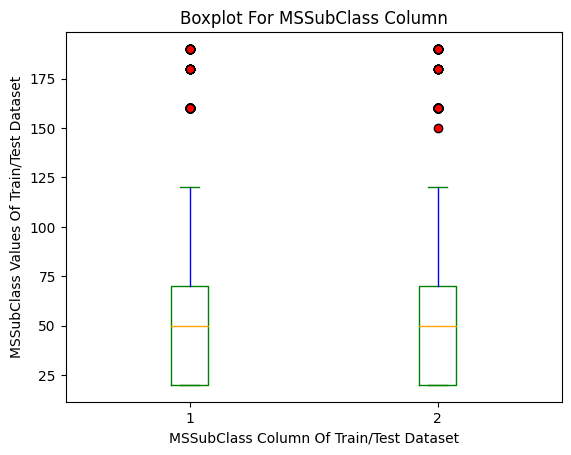

In [20]:
# Find outliers for MSSubClass column in train/test dataset
train_x = train_pp_df['MSSubClass']
test_x = test_pp_df['MSSubClass']
plt.boxplot([train_x,test_x], boxprops=dict(color='green'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), 
            medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.title('Boxplot For MSSubClass Column')
plt.xlabel('MSSubClass Column Of Train/Test Dataset')
plt.ylabel('MSSubClass Values Of Train/Test Dataset')
plt.show()

**It is a categorical column, hence no outliers treatment required.**

# *(II) Train/Test Dataset LotFrontage Columns' Outliers Treatment*

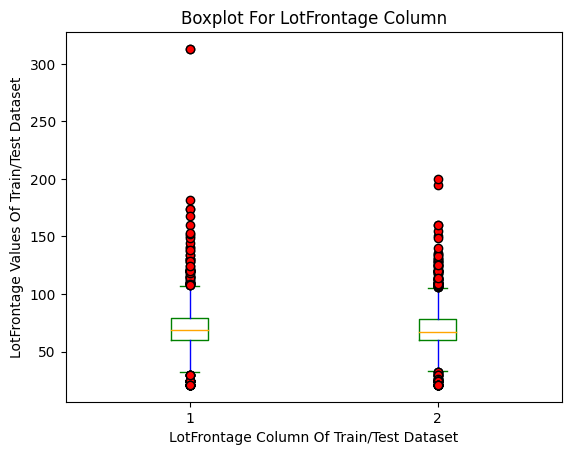

In [21]:
# Find outliers for LotFrontage column in train/test dataset
train_x = train_pp_df['LotFrontage']
test_x = test_pp_df['LotFrontage']
plt.boxplot([train_x,test_x], boxprops=dict(color='green'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), 
            medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.title('Boxplot For LotFrontage Column')
plt.xlabel('LotFrontage Column Of Train/Test Dataset')
plt.ylabel('LotFrontage Values Of Train/Test Dataset')
plt.show()

In [22]:
# Find lower and upper boundry of outliers for LotFrontage column in train/test dataset
q1, q3 = np.percentile(train_pp_df['LotFrontage'], [25,75])
iqr = q3 - q1
lower_boundry = q1 - 1.5*iqr
upper_boundry = q3 + 1.5*iqr
print("LB & UB of outliers in LotFrontage column for train dataset :-", lower_boundry, upper_boundry)

print("**********************************")

q1, q3 = np.percentile(test_pp_df['LotFrontage'], [25,75])
iqr = q3 - q1
lower_boundry = q1 - 1.5*iqr
upper_boundry = q3 + 1.5*iqr
print("LB & UB of outliers in LotFrontage column for test dataset :-", lower_boundry, upper_boundry)

LB & UB of outliers in LotFrontage column for train dataset :- 31.5 107.5
**********************************
LB & UB of outliers in LotFrontage column for test dataset :- 33.0 105.0


In [23]:
# Replace outliers with median value for LotFrontage column in train/test dataset
median = train_pp_df['LotFrontage'].median()
train_pp_df.loc[train_pp_df['LotFrontage'] > 107.5, 'LotFrontage'] = median
train_pp_df.loc[train_pp_df['LotFrontage'] < 31.5, 'LotFrontage'] = median
print("The max & min value of LotFrontage column in train dataset :-", train_pp_df['LotFrontage'].max(),"&",train_pp_df['LotFrontage'].min())
print("The shape of LotFrontage column is :-", train_pp_df['LotFrontage'].shape)
print("************************************")

median = test_pp_df['LotFrontage'].median()
test_pp_df.loc[test_pp_df['LotFrontage'] > 105.0, 'LotFrontage'] = median
test_pp_df.loc[test_pp_df['LotFrontage'] < 33.0, 'LotFrontage'] = median
print("The max & min value of LotFrontage column in test dataset :-", test_pp_df['LotFrontage'].max(),"&",test_pp_df['LotFrontage'].min())
print("The shape of LotFrontage column is :-", test_pp_df['LotFrontage'].shape)

The max & min value of LotFrontage column in train dataset :- 107.0 & 32.0
The shape of LotFrontage column is :- (1460,)
************************************
The max & min value of LotFrontage column in test dataset :- 105.0 & 33.0
The shape of LotFrontage column is :- (1459,)


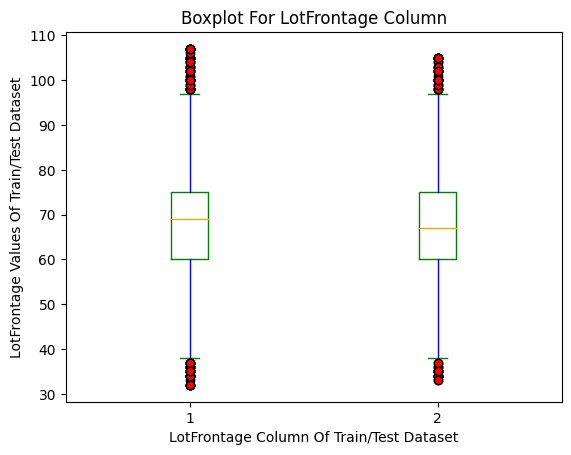

In [24]:
# Verify outliers for LotFrontage column in train/test dataset
train_x = train_pp_df['LotFrontage']
test_x = test_pp_df['LotFrontage']
plt.boxplot([train_x,test_x], boxprops=dict(color='green'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), 
            medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.title('Boxplot For LotFrontage Column')
plt.xlabel('LotFrontage Column Of Train/Test Dataset')
plt.ylabel('LotFrontage Values Of Train/Test Dataset')
plt.show()

# *(III) Train/Test Dataset LotArea Columns' Outliers Treatment*

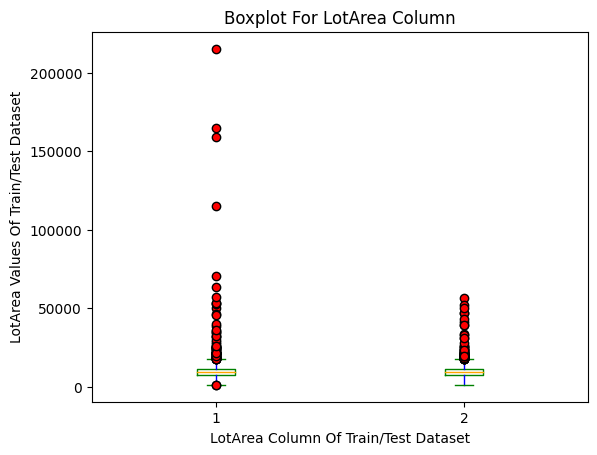

In [25]:
# Find outliers for LotArea column in train/test dataset
train_x = train_pp_df['LotArea']
test_x = test_pp_df['LotArea']
plt.boxplot([train_x,test_x], boxprops=dict(color='green'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), 
            medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.title('Boxplot For LotArea Column')
plt.xlabel('LotArea Column Of Train/Test Dataset')
plt.ylabel('LotArea Values Of Train/Test Dataset')
plt.show()

In [26]:
# Find lower and upper boundry of outliers for LotArea column in train dataset
q1, q3 = np.percentile(train_pp_df['LotArea'], [25,75])
iqr = q3 - q1
lower_boundry = q1 - 1.5*iqr
upper_boundry = q3 + 1.5*iqr
print("LB & UB of outliers in LotArea column for train dataset :-", lower_boundry, upper_boundry)

LB & UB of outliers in LotArea column for train dataset :- 1481.5 17673.5


In [27]:
# Replace outliers with median value for LotArea column in train dataset
median = train_pp_df['LotArea'].median()
train_pp_df.loc[train_pp_df['LotArea'] > 17673.5, 'LotArea'] = median
train_pp_df.loc[train_pp_df['LotArea'] < 1481.5, 'LotArea'] = median
print("The max & min value of LotArea column in train dataset :-", train_pp_df['LotArea'].max(),"&",train_pp_df['LotArea'].min())
print("The shape of LotArea column is :-", train_pp_df['LotArea'].shape)

The max & min value of LotArea column in train dataset :- 17671.0 & 1491.0
The shape of LotArea column is :- (1460,)


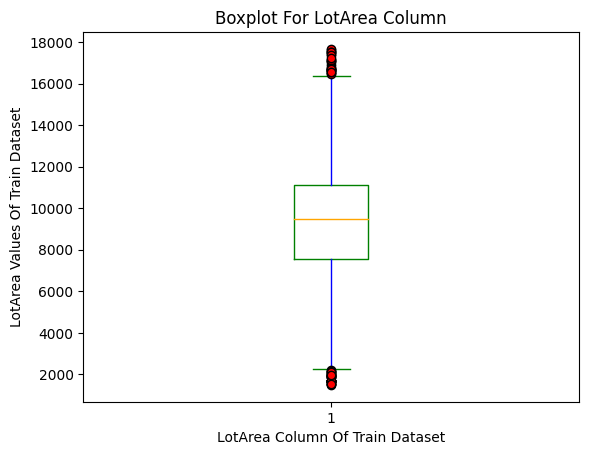

In [28]:
# Verify outliers for LotArea column in train dataset
train_x = train_pp_df['LotArea']
plt.boxplot(train_x, boxprops=dict(color='green'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), 
            medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.title('Boxplot For LotArea Column')
plt.xlabel('LotArea Column Of Train Dataset')
plt.ylabel('LotArea Values Of Train Dataset')
plt.show()

# *(IV) Train Dataset Remaining Columns' Outliers Treatment*

In [29]:
# Replace outliers with median value for rest of the columns in train dataset
median1 = train_pp_df['YearBuilt'].median()
train_pp_df.loc[train_pp_df['YearBuilt'] < 1885.0, 'YearBuilt'] = median1

median2 = train_pp_df['MasVnrArea'].median()
train_pp_df.loc[train_pp_df['MasVnrArea'] > 410.625, 'MasVnrArea'] = median2
train_pp_df.loc[train_pp_df['MasVnrArea'] < -246.375, 'MasVnrArea'] = median2

median3 = train_pp_df['BsmtFinSF1'].median()
train_pp_df.loc[train_pp_df['BsmtFinSF1'] > 1780.625, 'BsmtFinSF1'] = median3
train_pp_df.loc[train_pp_df['BsmtFinSF1'] < -1068.375, 'BsmtFinSF1'] = median3

median4 = train_pp_df['BsmtUnfSF'].median()
train_pp_df.loc[train_pp_df['BsmtUnfSF'] > 1685.5, 'BsmtUnfSF'] = median4
train_pp_df.loc[train_pp_df['BsmtUnfSF'] < -654.5, 'BsmtUnfSF'] = median4

median5 = train_pp_df['TotalBsmtSF'].median()
train_pp_df.loc[train_pp_df['TotalBsmtSF'] > 2052.0, 'TotalBsmtSF'] = median5
train_pp_df.loc[train_pp_df['TotalBsmtSF'] < 42.0, 'TotalBsmtSF'] = median5

median6 = train_pp_df['1stFlrSF'].median()
train_pp_df.loc[train_pp_df['1stFlrSF'] > 2155.125, '1stFlrSF'] = median6
train_pp_df.loc[train_pp_df['1stFlrSF'] < 118.125, '1stFlrSF'] = median6

median7 = train_pp_df['2ndFlrSF'].median()
train_pp_df.loc[train_pp_df['2ndFlrSF'] > 1820.0, '2ndFlrSF'] = median7
train_pp_df.loc[train_pp_df['2ndFlrSF'] < -1092.0, '2ndFlrSF'] = median7

median8 = train_pp_df['GrLivArea'].median()
train_pp_df.loc[train_pp_df['GrLivArea'] > 2747.625, 'GrLivArea'] = median8
train_pp_df.loc[train_pp_df['GrLivArea'] < 158.625, 'GrLivArea'] = median8

median9 = train_pp_df['GarageYrBlt'].median()
train_pp_df.loc[train_pp_df['GarageYrBlt'] > 2059.5, 'GarageYrBlt'] = median9
train_pp_df.loc[train_pp_df['GarageYrBlt'] < 1903.5, 'GarageYrBlt'] = median9

median10 = train_pp_df['GarageArea'].median()
train_pp_df.loc[train_pp_df['GarageArea'] > 938.25, 'GarageArea'] = median10
train_pp_df.loc[train_pp_df['GarageArea'] < -27.75, 'GarageArea'] = median10

median11 = train_pp_df['WoodDeckSF'].median()
train_pp_df.loc[train_pp_df['WoodDeckSF'] > 420.0, 'WoodDeckSF'] = median11
train_pp_df.loc[train_pp_df['WoodDeckSF'] < -252.0, 'WoodDeckSF'] = median11

median12 = train_pp_df['OpenPorchSF'].median()
train_pp_df.loc[train_pp_df['OpenPorchSF'] > 170.0, 'OpenPorchSF'] = median12
train_pp_df.loc[train_pp_df['OpenPorchSF'] < -102.0, 'OpenPorchSF'] = median12

median13 = train_pp_df['SalePrice'].median()
train_pp_df.loc[train_pp_df['SalePrice'] > 340037.5, 'SalePrice'] = median13
train_pp_df.loc[train_pp_df['SalePrice'] < 3937.5, 'SalePrice'] = median13

# *(V) Test Dataset Remaining Columns' Outliers Treatment*

In [30]:
# Replace outliers with median value for rest of the columns in test dataset
median21 = test_pp_df['YearBuilt'].median()
test_pp_df.loc[test_pp_df['YearBuilt'] < 1881.0, 'YearBuilt'] = median21

median22 = test_pp_df['MasVnrArea'].median()
test_pp_df.loc[test_pp_df['MasVnrArea'] > 405.0, 'MasVnrArea'] = median22
test_pp_df.loc[test_pp_df['MasVnrArea'] < -243.0, 'MasVnrArea'] = median22

median23 = test_pp_df['BsmtFinSF1'].median()
test_pp_df.loc[test_pp_df['BsmtFinSF1'] > 1880.0, 'BsmtFinSF1'] = median23
test_pp_df.loc[test_pp_df['BsmtFinSF1'] < -1128.0, 'BsmtFinSF1'] = median23

median24 = test_pp_df['BsmtUnfSF'].median()
test_pp_df.loc[test_pp_df['BsmtUnfSF'] > 1664.5, 'BsmtUnfSF'] = median24
test_pp_df.loc[test_pp_df['BsmtUnfSF'] < -647.5, 'BsmtUnfSF'] = median24

median25 = test_pp_df['TotalBsmtSF'].median()
test_pp_df.loc[test_pp_df['TotalBsmtSF'] > 2084.0, 'TotalBsmtSF'] = median25
test_pp_df.loc[test_pp_df['TotalBsmtSF'] < 4.0, 'TotalBsmtSF'] = median25

median26 = test_pp_df['1stFlrSF'].median()
test_pp_df.loc[test_pp_df['1stFlrSF'] > 2146.0, '1stFlrSF'] = median26
test_pp_df.loc[test_pp_df['1stFlrSF'] < 110.0, '1stFlrSF'] = median26

median27 = test_pp_df['2ndFlrSF'].median()
test_pp_df.loc[test_pp_df['2ndFlrSF'] > 1690.0, '2ndFlrSF'] = median27
test_pp_df.loc[test_pp_df['2ndFlrSF'] < -1014.0, '2ndFlrSF'] = median27

median28 = test_pp_df['GrLivArea'].median()
test_pp_df.loc[test_pp_df['GrLivArea'] > 2626.25, 'GrLivArea'] = median28
test_pp_df.loc[test_pp_df['GrLivArea'] < 212.25, 'GrLivArea'] = median28

median29 = test_pp_df['GarageYrBlt'].median()
test_pp_df.loc[test_pp_df['GarageYrBlt'] > 2061.75, 'GarageYrBlt'] = median29
test_pp_df.loc[test_pp_df['GarageYrBlt'] < 1899.75, 'GarageYrBlt'] = median29

median30 = test_pp_df['GarageArea'].median()
test_pp_df.loc[test_pp_df['GarageArea'] > 963.0, 'GarageArea'] = median30
test_pp_df.loc[test_pp_df['GarageArea'] < -69.0, 'GarageArea'] = median30

median31 = test_pp_df['WoodDeckSF'].median()
test_pp_df.loc[test_pp_df['WoodDeckSF'] > 420.0, 'WoodDeckSF'] = median31
test_pp_df.loc[test_pp_df['WoodDeckSF'] < -252.0, 'WoodDeckSF'] = median31

median32 = test_pp_df['OpenPorchSF'].median()
test_pp_df.loc[test_pp_df['OpenPorchSF'] > 180.0, 'OpenPorchSF'] = median32
test_pp_df.loc[test_pp_df['OpenPorchSF'] < -108.0, 'OpenPorchSF'] = median32

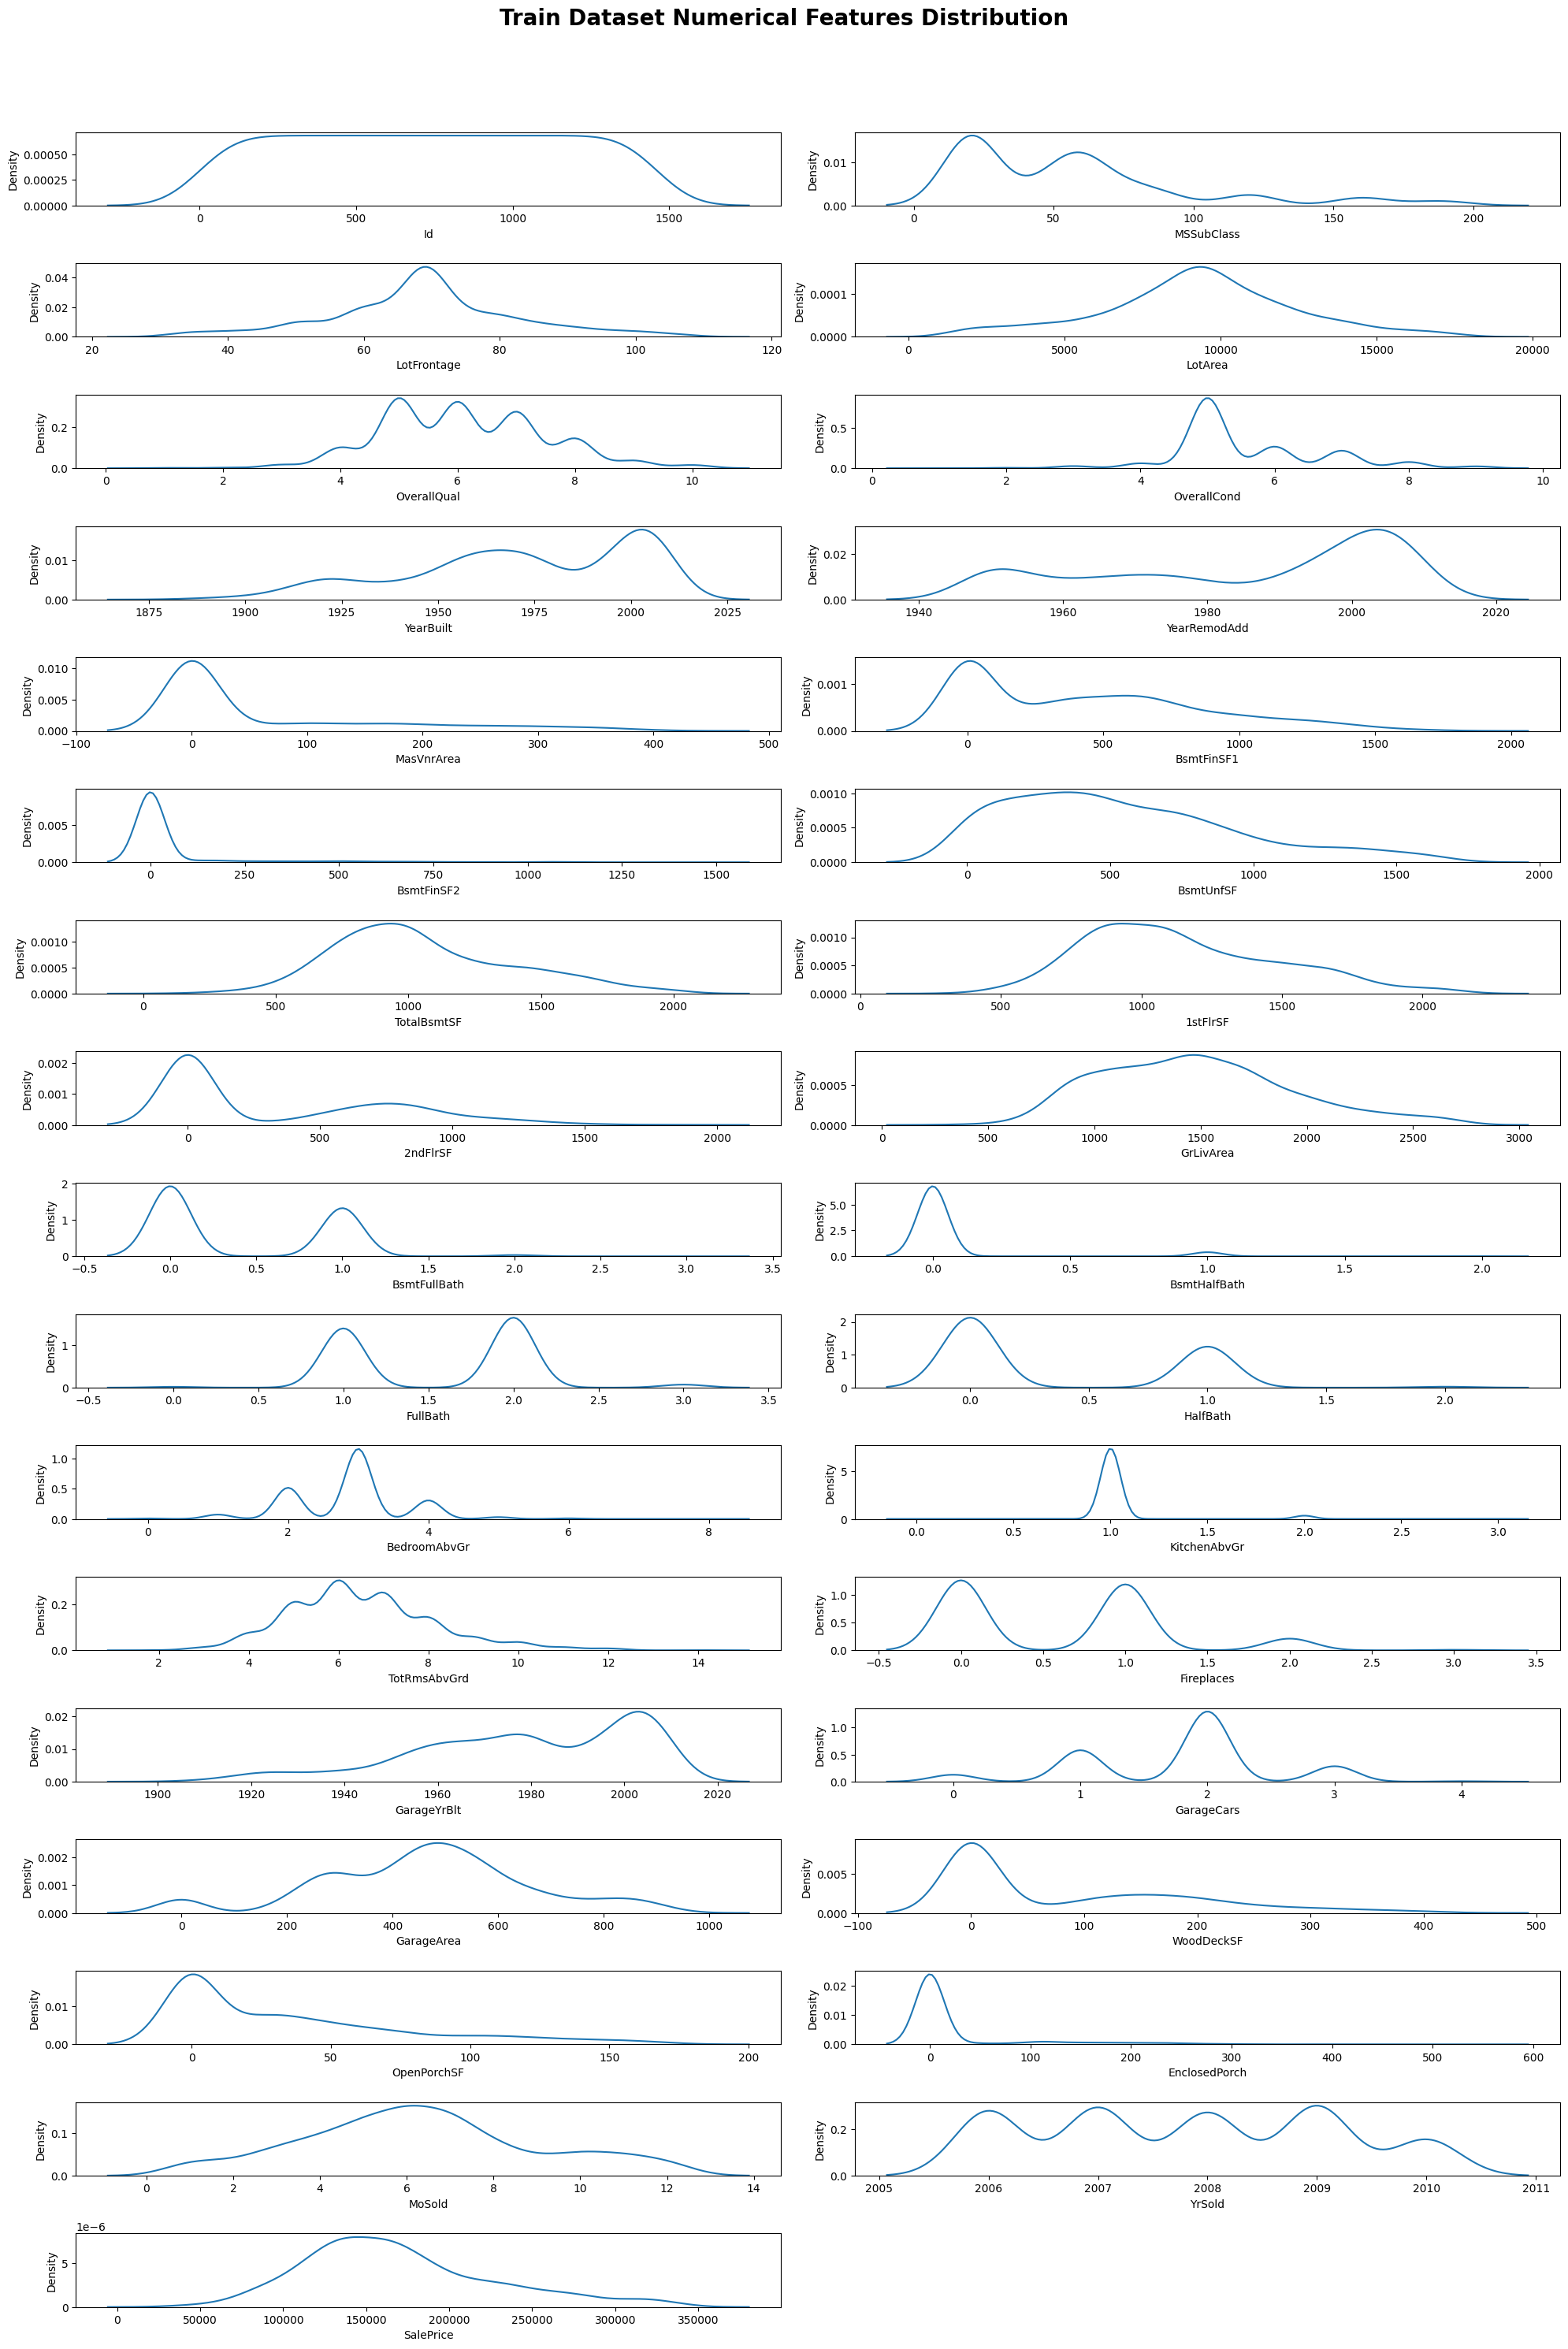

In [31]:
# Train dataset numerical columns distribution after treating outliers
plt.figure(figsize=(20, 50))
plt.suptitle('Train Dataset Numerical Features Distribution', fontsize=20, fontweight='bold', y=1.02)

for i,col in enumerate(train_num_df):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(train_pp_df[col])
    plt.xlabel(col)
    plt.tight_layout()

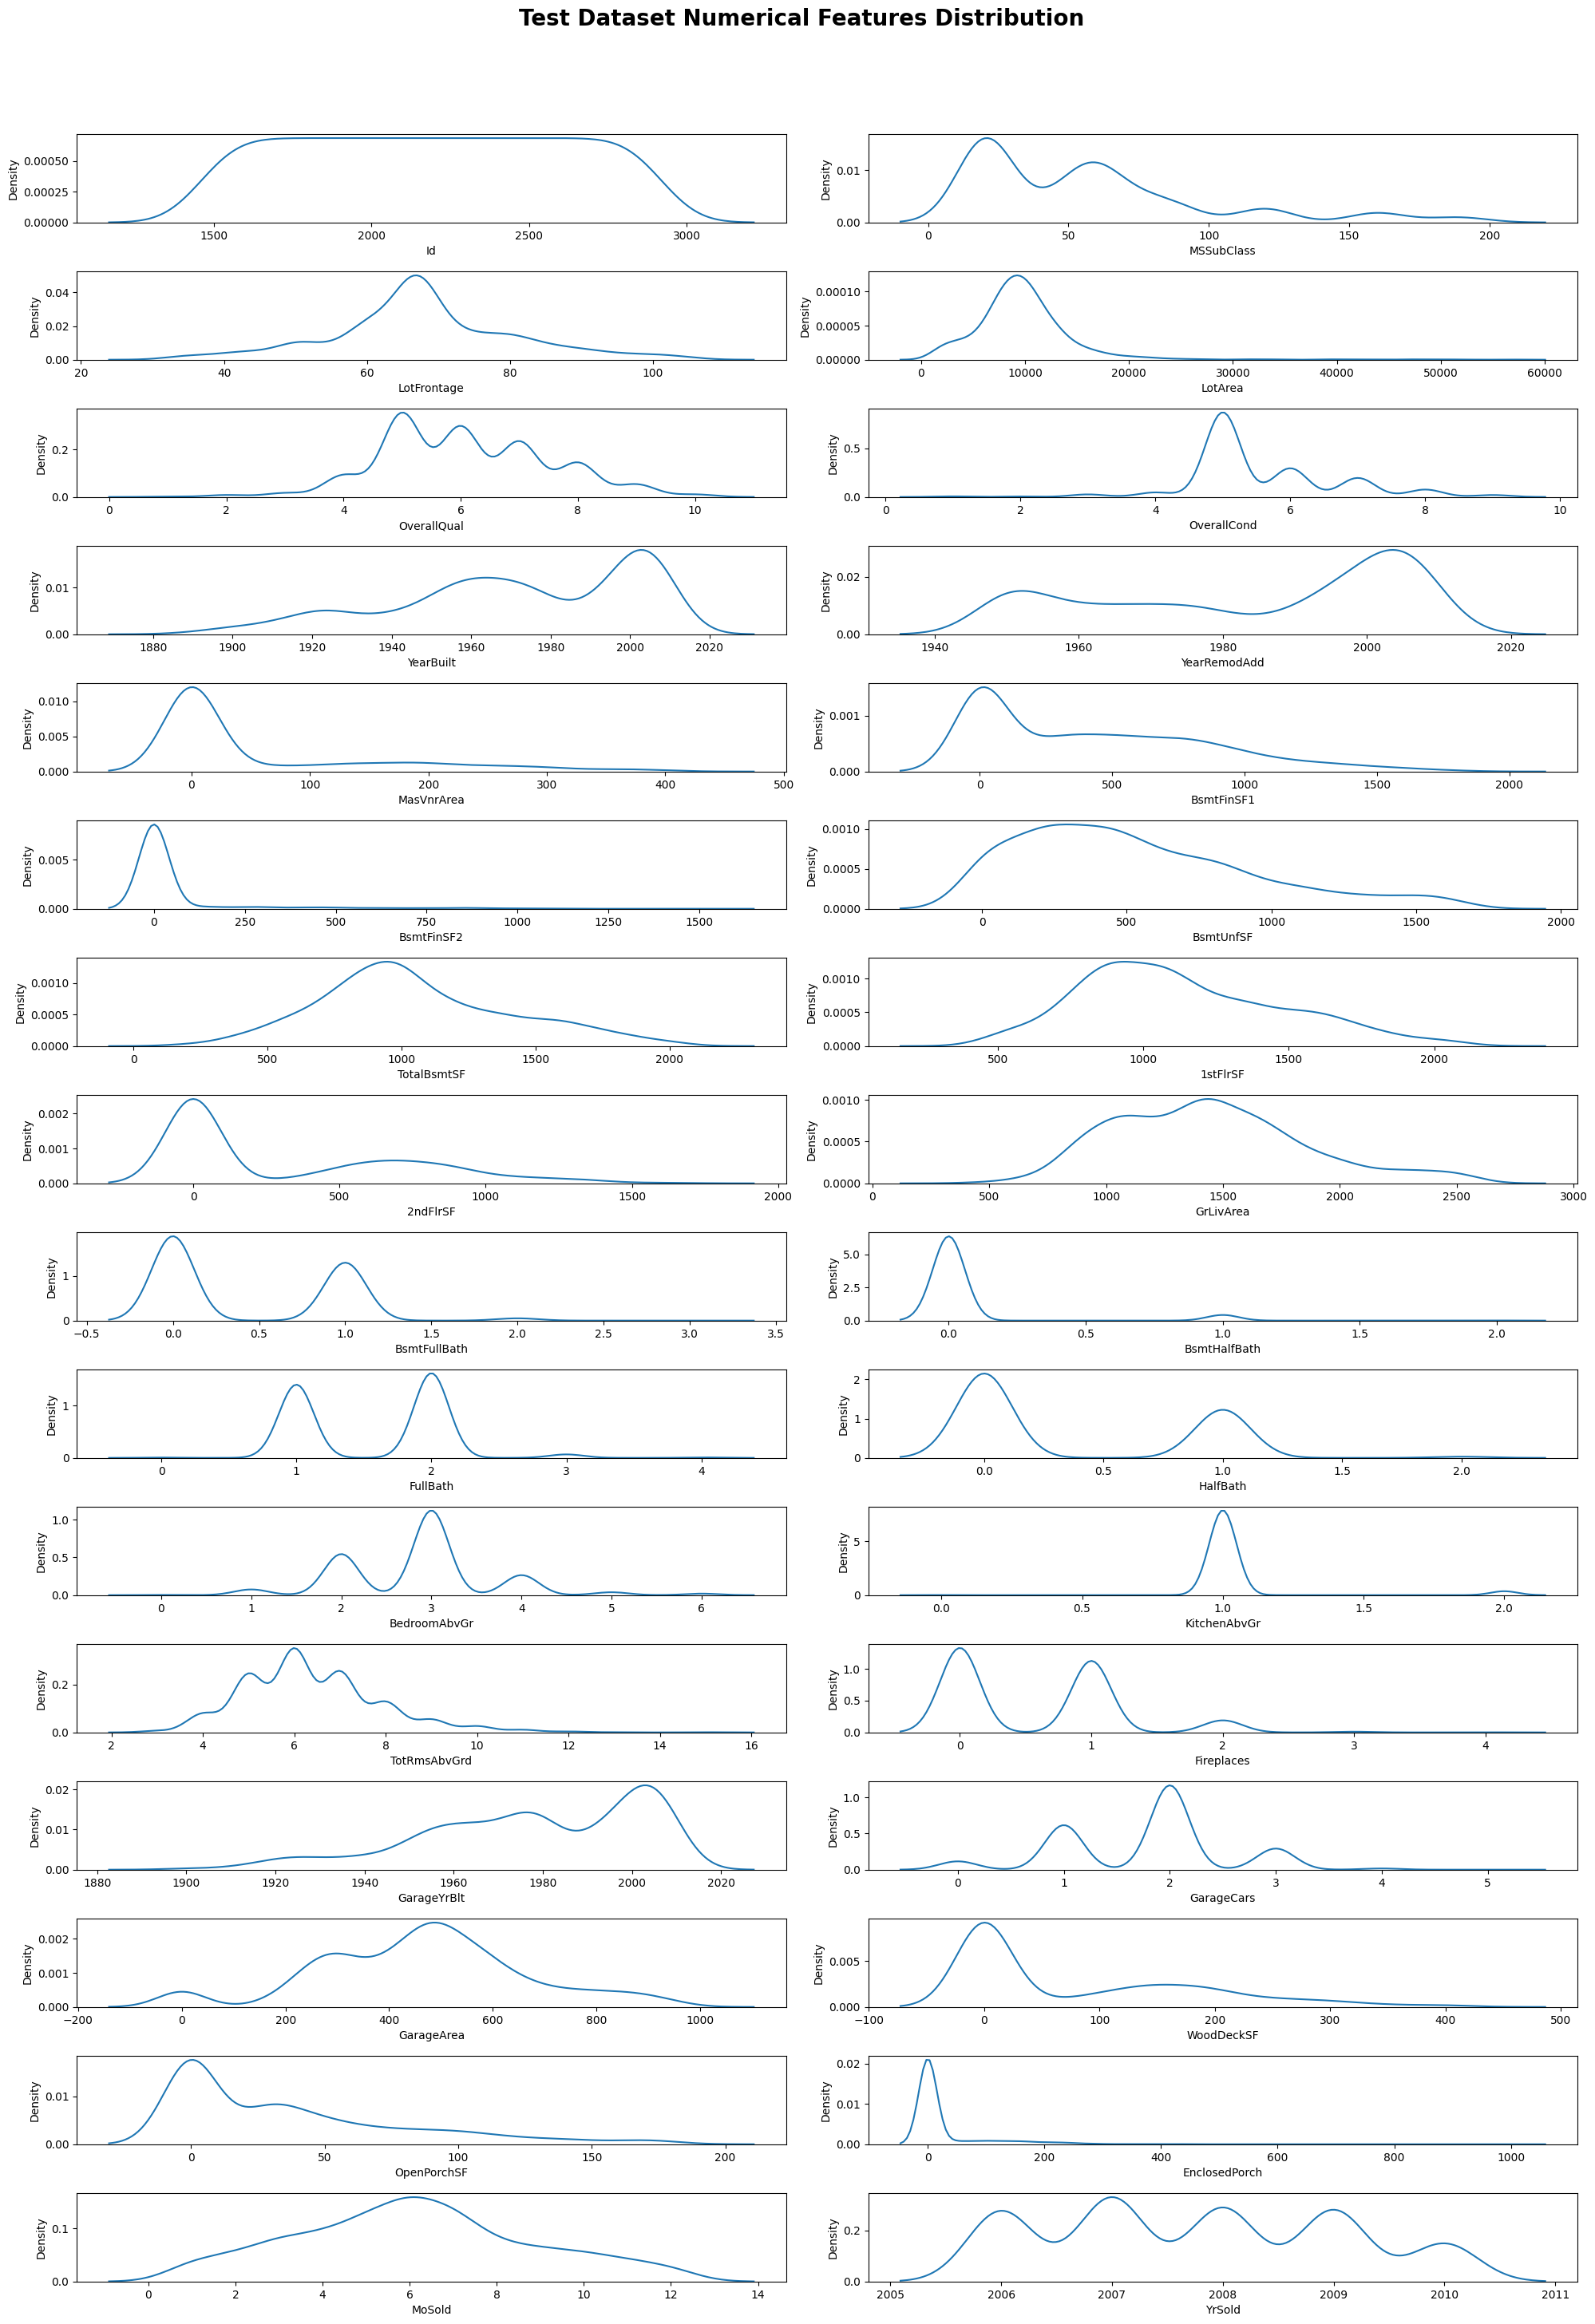

In [32]:
# Test dataset numerical columns distribution after treating outliers
plt.figure(figsize=(20, 50))
plt.suptitle('Test Dataset Numerical Features Distribution', fontsize=20, fontweight='bold', y=1.02)

for i,col in enumerate(test_num_df):
    plt.subplot(29, 2, i+1)
    sns.kdeplot(test_pp_df[col])
    plt.xlabel(col)
    plt.tight_layout()

# **12. Ordinal Encoding Of Categorical Columns**

In [33]:
# Find the categorical columns name in train/test dataset
train_cat_df = train_pp_df.select_dtypes(include="object").keys()
print("Train dataset categorical columns shape :-", train_cat_df.shape)
print("Train dataset categorical columns name :-\n", train_cat_df)

print("*************************************")

test_cat_df = test_pp_df.select_dtypes(include="object").keys()
print("Test dataset categorical columns shape :-", test_cat_df.shape)
print("Test dataset categorical columns name :-\n", test_cat_df)

Train dataset categorical columns shape :- (39,)
Train dataset categorical columns name :-
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
*************************************
Test dataset categorical columns shape :- (39,)
Test dataset categorical columns name :-
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 

In [34]:
# Use OrdinalEncoder to convert categorical columns categories into numerical values for train dataset

# Initialize OrdinalEncoder
oe = OrdinalEncoder()

# Fit the OrdinalEncoder
train_pp_df[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
             'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
             'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
             'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']] = oe.fit_transform(
            train_pp_df[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
                         'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                         'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                         'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
                         'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']])

print("Task completed successfully!")

Task completed successfully!


In [35]:
# Verify train dataset categorical columns values encoded into numerical
train_pp_df.to_csv('/kaggle/working/train_pp_df.csv', index=False)
print("Train dataset shape :-", train_pp_df.shape)
train_pp_df.head()

Train dataset shape :- (1460, 72)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3.0,65.0,8450.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,2003,2003,1.0,1.0,12.0,13.0,1.0,196.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,706.0,5.0,0,150.0,856.0,1.0,0.0,1.0,4.0,856,854,1710,1,0,2,1,3,1,2.0,8,6.0,0,5.0,1.0,2003.0,1.0,2,548,4.0,4.0,2.0,0,61,0,2,2008,8.0,4.0,208500
1,2,20,3.0,80.0,9600.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,6,8,1976,1976,1.0,1.0,8.0,8.0,3.0,0.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,978.0,5.0,0,284.0,1262.0,1.0,0.0,1.0,4.0,1262,0,1262,0,1,2,0,3,1,3.0,6,6.0,1,4.0,1.0,1976.0,1.0,2,460,4.0,4.0,2.0,298,0,0,5,2007,8.0,4.0,181500
2,3,60,3.0,68.0,11250.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,2001,2002,1.0,1.0,12.0,13.0,1.0,162.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,486.0,5.0,0,434.0,920.0,1.0,0.0,1.0,4.0,920,866,1786,1,0,2,1,3,1,2.0,6,6.0,1,4.0,1.0,2001.0,1.0,2,608,4.0,4.0,2.0,0,42,0,9,2008,8.0,4.0,223500
3,4,70,3.0,60.0,9550.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,7,5,1915,1970,1.0,1.0,13.0,15.0,3.0,0.0,3.0,4.0,0.0,3.0,1.0,3.0,0.0,216.0,5.0,0,540.0,756.0,1.0,2.0,1.0,4.0,961,756,1717,1,0,1,0,3,1,2.0,7,6.0,1,2.0,5.0,1998.0,2.0,3,642,4.0,4.0,2.0,0,35,272,2,2006,8.0,0.0,140000
4,5,60,3.0,84.0,14260.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,8,5,2000,2000,1.0,1.0,12.0,13.0,1.0,350.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,655.0,5.0,0,490.0,1145.0,1.0,0.0,1.0,4.0,1145,1053,2198,1,0,2,1,4,1,2.0,9,6.0,1,4.0,1.0,2000.0,1.0,3,836,4.0,4.0,2.0,192,84,0,12,2008,8.0,4.0,250000


In [36]:
# Use OrdinalEncoder to convert categorical columns categories into numerical values for test dataset

# Initialize OrdinalEncoder
oe1 = OrdinalEncoder()

# Fit the OrdinalEncoder
test_pp_df[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
            'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']] = oe1.fit_transform(
            test_pp_df[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
                        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
                        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']])

print("Task completed successfully!")

Task completed successfully!


In [37]:
# Verify test dataset categorical columns values encoded into numerical
test_pp_df.to_csv('/kaggle/working/test_pp_df.csv', index=False)
print("Test dataset shape :-", test_pp_df.shape)
test_pp_df.head()

Test dataset shape :- (1459, 71)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2.0,80.0,11622,1.0,3.0,3.0,0.0,4.0,0.0,12.0,1.0,2.0,0.0,2.0,5,6,1961,1961,1.0,0.0,10.0,12.0,3.0,0.0,3.0,4.0,1.0,3.0,3.0,3.0,4.0,468.0,3.0,144.0,270.0,882.0,0.0,4.0,1.0,3.0,896,0,896,0.0,0.0,1,0,2,1,3.0,5,6.0,0,5.0,1.0,1961.0,2.0,1.0,730.0,3.0,4.0,2.0,140,0,0,6,2010,8.0,4.0
1,1462,20,3.0,81.0,14267,1.0,0.0,3.0,0.0,0.0,0.0,12.0,2.0,2.0,0.0,2.0,6,6,1958,1958,3.0,0.0,11.0,13.0,1.0,108.0,3.0,4.0,1.0,3.0,3.0,3.0,0.0,923.0,5.0,0.0,406.0,1329.0,0.0,4.0,1.0,3.0,1329,0,1329,0.0,0.0,1,1,3,1,2.0,6,6.0,0,5.0,1.0,1958.0,2.0,1.0,312.0,3.0,4.0,2.0,393,36,0,6,2010,8.0,4.0
2,1463,60,3.0,74.0,13830,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,0.0,4.0,5,5,1997,1998,1.0,0.0,10.0,12.0,3.0,0.0,3.0,4.0,2.0,2.0,3.0,3.0,2.0,791.0,5.0,0.0,137.0,928.0,0.0,2.0,1.0,3.0,928,701,1629,0.0,0.0,2,1,3,1,3.0,6,6.0,1,4.0,1.0,1997.0,0.0,2.0,482.0,3.0,4.0,2.0,212,34,0,3,2010,8.0,4.0
3,1464,60,3.0,78.0,9978,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,0.0,4.0,6,6,1998,1998,1.0,0.0,10.0,12.0,1.0,20.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,602.0,5.0,0.0,324.0,926.0,0.0,0.0,1.0,3.0,926,678,1604,0.0,0.0,2,1,3,1,2.0,7,6.0,1,2.0,1.0,1998.0,0.0,2.0,470.0,3.0,4.0,2.0,360,36,0,6,2010,8.0,4.0
4,1465,120,3.0,43.0,5005,1.0,0.0,1.0,0.0,4.0,0.0,22.0,2.0,2.0,4.0,2.0,8,5,1992,1992,1.0,0.0,6.0,6.0,3.0,0.0,2.0,4.0,2.0,2.0,3.0,3.0,0.0,263.0,5.0,0.0,1017.0,1280.0,0.0,0.0,1.0,3.0,1280,0,1280,0.0,0.0,2,0,2,1,2.0,5,6.0,0,5.0,1.0,1992.0,1.0,2.0,506.0,3.0,4.0,2.0,0,82,0,1,2010,8.0,4.0


# **13. Dataset Feature Engineering**

# *(I) Merge Similar Categories Columns*

In [38]:
# Copy train/test dataset
train_merge_df = train_pp_df.copy()

test_merge_df = test_pp_df.copy()

print("Task completed successfully!")

Task completed successfully!


In [39]:
# Shape of train/test dataset
print("Train/Test Merge Dataset Shape :-", train_merge_df.shape, test_merge_df.shape)

Train/Test Merge Dataset Shape :- (1460, 72) (1459, 71)


In [40]:
# Merge numerical columns in train/test dataset
train_merge_df['OverallGrade'] = 0.5*(train_merge_df['OverallQual']) + 0.5*(train_merge_df['OverallCond'])
train_merge_df['HouseAge'] = train_merge_df['YrSold'] - train_merge_df['YearBuilt']
train_merge_df['GarageAge'] = train_merge_df['YrSold'] - train_merge_df['GarageYrBlt']
train_merge_df['RemodAge'] = train_merge_df['YrSold'] - train_merge_df['YearRemodAdd']
train_merge_df['BsmtFinSF'] = train_merge_df['BsmtFinSF1'] + train_merge_df['BsmtFinSF2']
train_merge_df['TotRmsAbvGrd'] = train_merge_df['TotRmsAbvGrd'] - train_merge_df['BedroomAbvGr']
train_merge_df['BsmtBath'] = train_merge_df['BsmtFullBath'] + 0.5*(train_merge_df['BsmtHalfBath'])
train_merge_df['TotalFlrBath'] = train_merge_df['FullBath'] + 0.5*(train_merge_df['HalfBath'])
train_merge_df['TotalPorchSF'] = train_merge_df['OpenPorchSF'] + train_merge_df['EnclosedPorch']

print("Task Completed Successfully!")

test_merge_df['OverallGrade'] = 0.5*(test_merge_df['OverallQual']) + 0.5*(test_merge_df['OverallCond'])
test_merge_df['HouseAge'] = test_merge_df['YrSold'] - test_merge_df['YearBuilt']
test_merge_df['GarageAge'] = test_merge_df['YrSold'] - test_merge_df['GarageYrBlt']
test_merge_df['RemodAge'] = test_merge_df['YrSold'] - test_merge_df['YearRemodAdd']
test_merge_df['BsmtFinSF'] = test_merge_df['BsmtFinSF1'] + test_merge_df['BsmtFinSF2']
test_merge_df['TotRmsAbvGrd'] = test_merge_df['TotRmsAbvGrd'] - test_merge_df['BedroomAbvGr']
test_merge_df['BsmtBath'] = test_merge_df['BsmtFullBath'] + 0.5*(test_merge_df['BsmtHalfBath'])
test_merge_df['TotalFlrBath'] = test_merge_df['FullBath'] + 0.5*(test_merge_df['HalfBath'])
test_merge_df['TotalPorchSF'] = test_merge_df['OpenPorchSF'] + test_merge_df['EnclosedPorch']

Task Completed Successfully!


In [41]:
# Merge categorical columns in train/test dataset
train_merge_df['OverallCondition'] = 0.5*(train_merge_df['Condition1']) + 0.5*(train_merge_df['Condition2'])
train_merge_df['OverallExterior'] = 0.5*(train_merge_df['Exterior1st']) + 0.5*(train_merge_df['Exterior2nd'])
train_merge_df['ExterGrade'] = 0.5*(train_merge_df['ExterQual']) + 0.5*(train_merge_df['ExterCond'])
train_merge_df['BsmtGrade'] = 0.5*(train_merge_df['BsmtQual']) + 0.5*(train_merge_df['BsmtCond'])
train_merge_df['BsmtFinTypeRating'] = 0.5*(train_merge_df['BsmtFinType1']) + 0.5*(train_merge_df['BsmtFinType2'])
train_merge_df['GarageGrade'] = 0.5*(train_merge_df['GarageQual']) + 0.5*(train_merge_df['GarageCond'])

print("Task Completed Successfully!")

test_merge_df['OverallCondition'] = 0.5*(test_merge_df['Condition1']) + 0.5*(test_merge_df['Condition2'])
test_merge_df['OverallExterior'] = 0.5*(test_merge_df['Exterior1st']) + 0.5*(test_merge_df['Exterior2nd'])
test_merge_df['ExterGrade'] = 0.5*(test_merge_df['ExterQual']) + 0.5*(test_merge_df['ExterCond'])
test_merge_df['BsmtGrade'] = 0.5*(test_merge_df['BsmtQual']) + 0.5*(test_merge_df['BsmtCond'])
test_merge_df['BsmtFinTypeRating'] = 0.5*(test_merge_df['BsmtFinType1']) + 0.5*(test_merge_df['BsmtFinType2'])
test_merge_df['GarageGrade'] = 0.5*(test_merge_df['GarageQual']) + 0.5*(test_merge_df['GarageCond'])

Task Completed Successfully!


In [42]:
#Drop the merged train/test columns
train_merge_df.drop(['OverallQual', 'OverallCond', 'YrSold', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 
                     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'OpenPorchSF', 'EnclosedPorch', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 
                     'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'GarageQual', 
                     'GarageCond', 'TotalBsmtSF'], axis=1, inplace=True)

print("Task Completed Successfully!")

test_merge_df.drop(['OverallQual', 'OverallCond', 'YrSold', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 
                     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'OpenPorchSF', 'EnclosedPorch', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 
                     'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'GarageQual', 
                     'GarageCond', 'TotalBsmtSF'], axis=1, inplace=True)

Task Completed Successfully!


In [43]:
# Train merged dataset shape and top 5 rows
print("Train merged dataset shape :-", train_merge_df.shape)
train_merge_df.head()

Train merged dataset shape :- (1460, 59)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,SalePrice,OverallGrade,HouseAge,GarageAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,1,60,3.0,65.0,8450.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,0.0,5.0,1.0,1.0,1.0,196.0,2.0,3.0,150.0,1.0,0.0,1.0,4.0,856,854,1710,3,1,2.0,5,6.0,0,5.0,1.0,1.0,2,548,2.0,0,2,8.0,4.0,208500,6.0,5,5.0,5,706.0,1.0,2.5,61,2.0,12.5,3.0,2.5,3.5,4.0
1,2,20,3.0,80.0,9600.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,1.0,284.0,1.0,0.0,1.0,4.0,1262,0,1262,3,1,3.0,3,6.0,1,4.0,1.0,1.0,2,460,2.0,298,5,8.0,4.0,181500,7.0,31,31.0,31,978.0,0.5,2.0,0,1.5,8.0,3.5,2.5,2.5,4.0
2,3,60,3.0,68.0,11250.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0,5.0,1.0,1.0,1.0,162.0,2.0,2.0,434.0,1.0,0.0,1.0,4.0,920,866,1786,3,1,2.0,3,6.0,1,4.0,1.0,1.0,2,608,2.0,0,9,8.0,4.0,223500,6.0,7,7.0,6,486.0,1.0,2.5,42,2.0,12.5,3.0,2.5,3.5,4.0
3,4,70,3.0,60.0,9550.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,0.0,5.0,1.0,1.0,3.0,0.0,0.0,3.0,540.0,1.0,2.0,1.0,4.0,961,756,1717,3,1,2.0,4,6.0,1,2.0,5.0,2.0,3,642,2.0,0,2,8.0,0.0,140000,6.0,91,8.0,36,216.0,1.0,1.0,307,2.0,14.0,3.5,2.0,2.5,4.0
4,5,60,3.0,84.0,14260.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,0.0,5.0,1.0,1.0,1.0,350.0,2.0,0.0,490.0,1.0,0.0,1.0,4.0,1145,1053,2198,4,1,2.0,5,6.0,1,4.0,1.0,1.0,3,836,2.0,192,12,8.0,4.0,250000,6.5,8,8.0,8,655.0,1.0,2.5,84,2.0,12.5,3.0,2.5,3.5,4.0


In [44]:
# Test merged dataset shape and top 5 rows
print("Test merged dataset shape :-", test_merge_df.shape)
test_merge_df.head()

Test merged dataset shape :- (1459, 58)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,OverallGrade,HouseAge,GarageAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,1461,20,2.0,80.0,11622,1.0,3.0,3.0,0.0,4.0,0.0,12.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,270.0,0.0,4.0,1.0,3.0,896,0,896,2,1,3.0,3,6.0,0,5.0,1.0,2.0,1.0,730.0,2.0,140,6,8.0,4.0,5.5,49,49.0,49,612.0,0.0,1.0,0,1.5,11.0,3.5,3.0,3.5,3.5
1,1462,20,3.0,81.0,14267,1.0,0.0,3.0,0.0,0.0,0.0,12.0,0.0,2.0,3.0,0.0,1.0,108.0,1.0,3.0,406.0,0.0,4.0,1.0,3.0,1329,0,1329,3,1,2.0,3,6.0,0,5.0,1.0,2.0,1.0,312.0,2.0,393,6,8.0,4.0,6.0,52,52.0,52,923.0,0.0,1.5,36,2.0,12.0,3.5,3.0,2.5,3.5
2,1463,60,3.0,74.0,13830,1.0,0.0,3.0,0.0,4.0,0.0,8.0,0.0,4.0,1.0,0.0,3.0,0.0,2.0,3.0,137.0,0.0,2.0,1.0,3.0,928,701,1629,3,1,3.0,3,6.0,1,4.0,1.0,0.0,2.0,482.0,2.0,212,3,8.0,4.0,5.0,13,13.0,12,791.0,0.0,2.5,34,2.0,11.0,3.5,2.5,3.5,3.5
3,1464,60,3.0,78.0,9978,1.0,0.0,3.0,0.0,4.0,0.0,8.0,0.0,4.0,1.0,0.0,1.0,20.0,2.0,3.0,324.0,0.0,0.0,1.0,3.0,926,678,1604,3,1,2.0,4,6.0,1,2.0,1.0,0.0,2.0,470.0,2.0,360,6,8.0,4.0,6.0,12,12.0,12,602.0,0.0,2.5,36,2.0,11.0,3.5,3.0,3.5,3.5
4,1465,120,3.0,43.0,5005,1.0,0.0,1.0,0.0,4.0,0.0,22.0,4.0,2.0,1.0,0.0,3.0,0.0,2.0,3.0,1017.0,0.0,0.0,1.0,3.0,1280,0,1280,2,1,2.0,3,6.0,0,5.0,1.0,1.0,2.0,506.0,2.0,0,1,8.0,4.0,6.5,18,18.0,18,263.0,0.0,2.0,82,2.0,6.0,3.0,2.5,2.5,3.5


# *(II) Dataset Correlations*

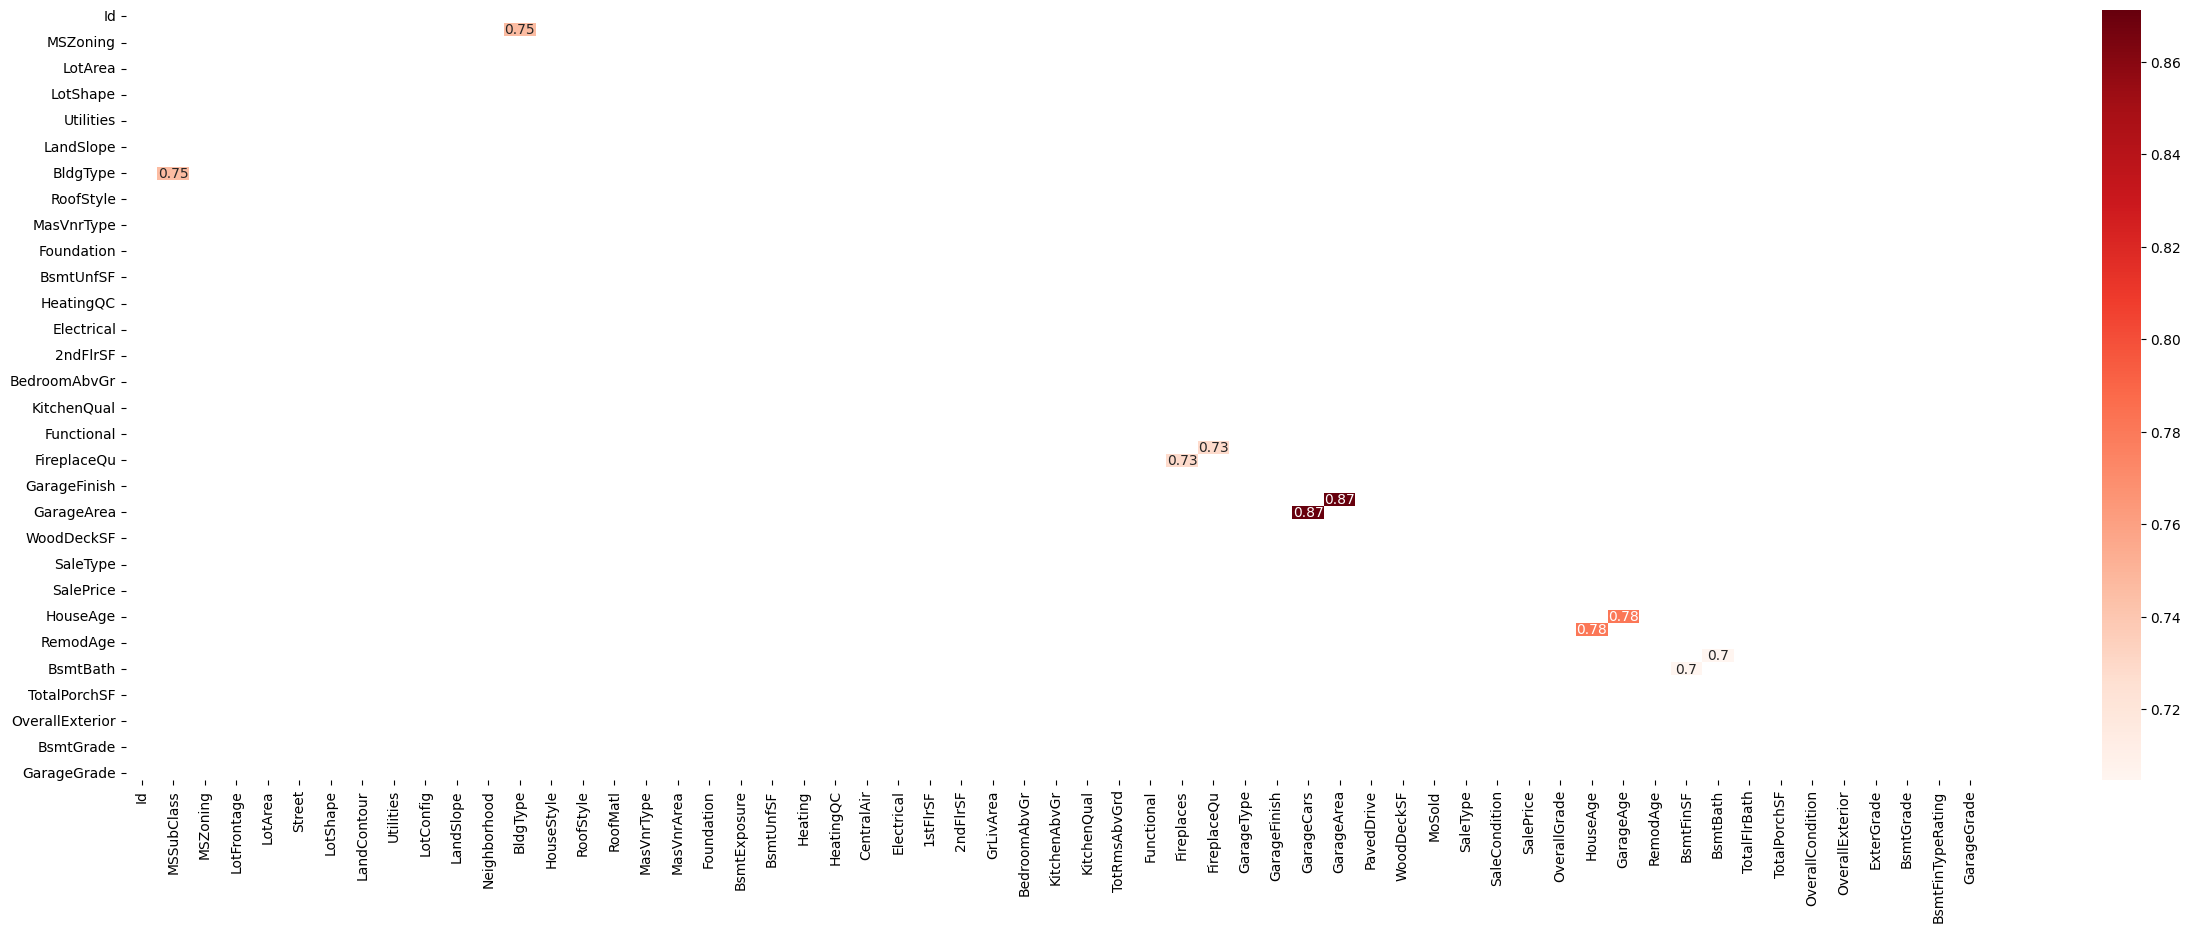

In [45]:
# Find correlation among numerical columns in train dataset
train_corr_matrix = train_merge_df.select_dtypes(include="number").corr().abs()
threshold = 0.7
train_corr_df = train_corr_matrix[(train_corr_matrix >= threshold) & (train_corr_matrix != 1.000)]
plt.figure(figsize=(30, 10))
sns.heatmap(train_corr_df, annot=True, cmap="Reds")
plt.show()

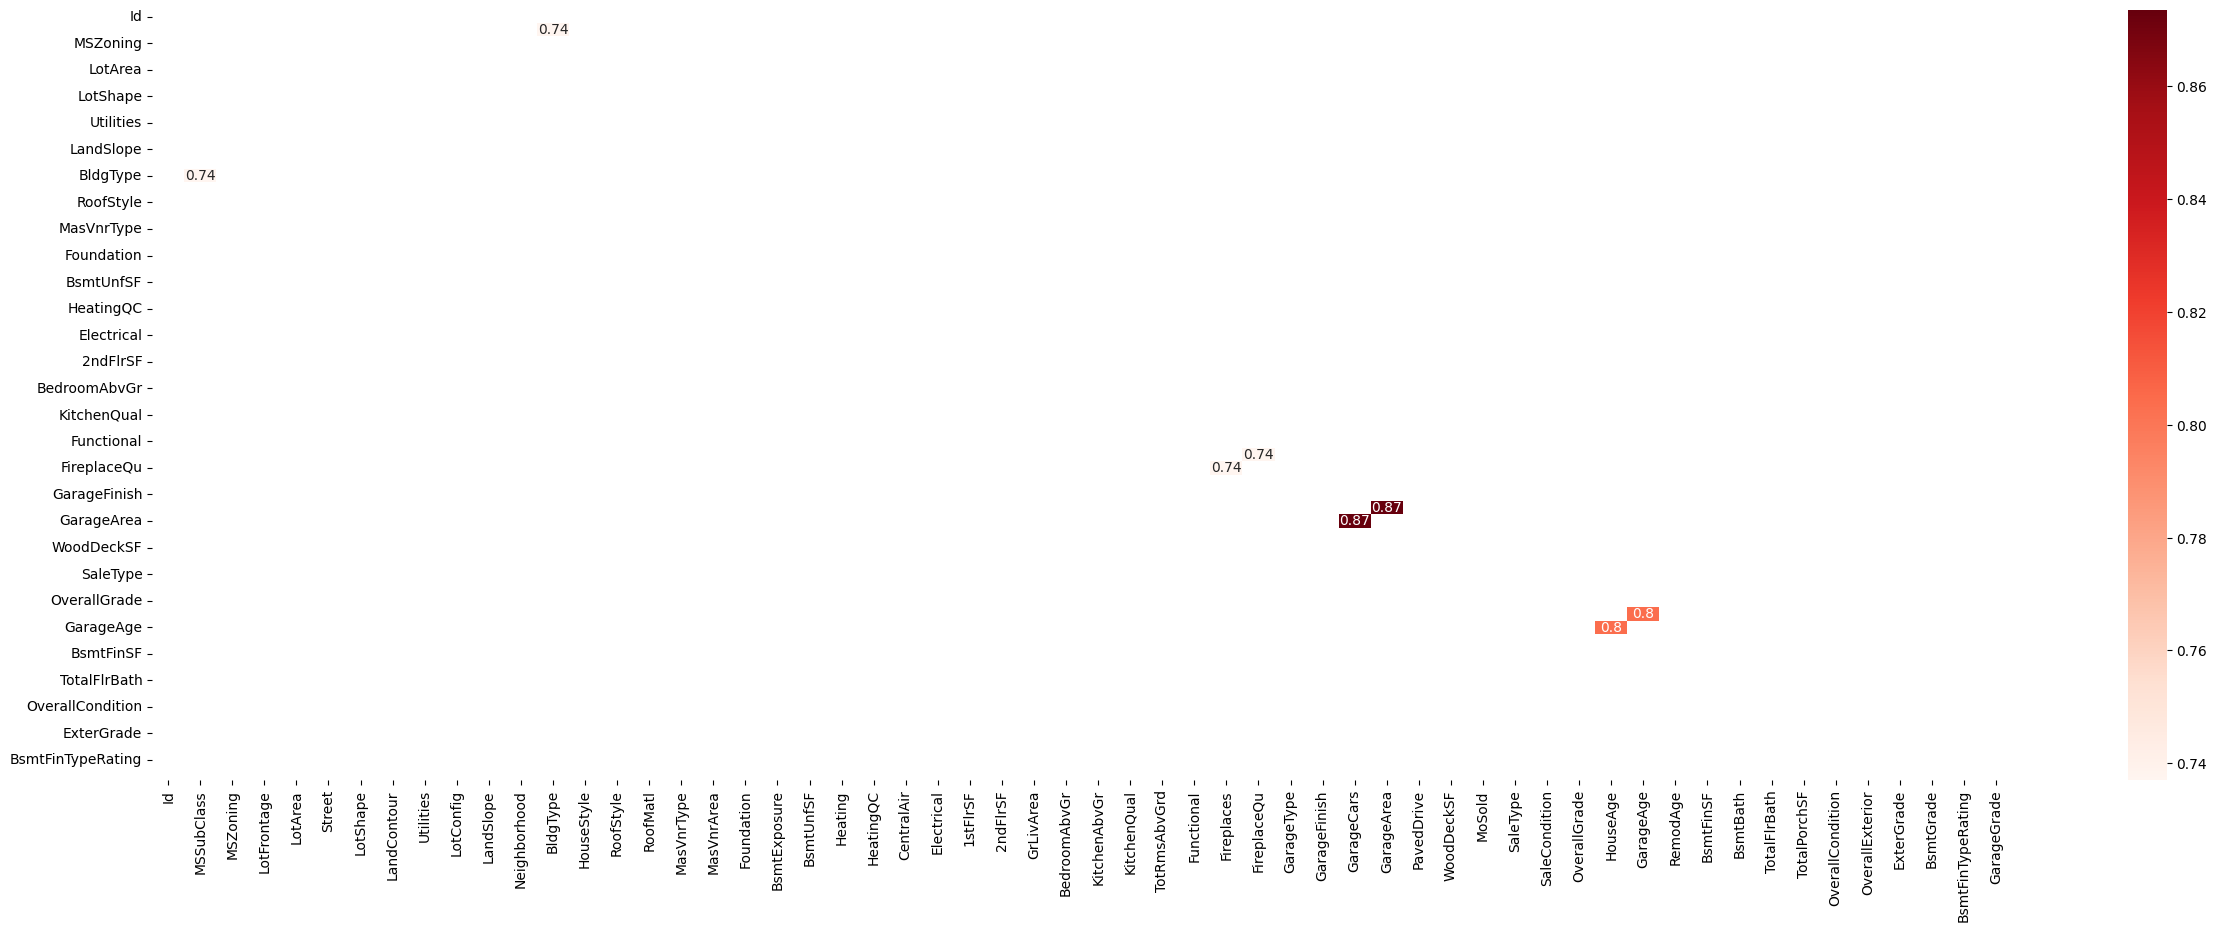

In [46]:
# Find correlation among numerical columns in test dataset
test_corr_matrix = test_merge_df.select_dtypes(include="number").corr().abs()
threshold = 0.7
test_corr_df = test_corr_matrix[(test_corr_matrix >= threshold) & (test_corr_matrix != 1.000)]
plt.figure(figsize=(30, 10))
sns.heatmap(test_corr_df, annot=True, cmap="Reds")
plt.show()

In [47]:
# Find highly correlated columns name in train/test dataset
train_upper = train_corr_matrix.where(np.triu(np.ones(train_corr_matrix.shape), k=1).astype(bool))
train_corr_info = [column for column in train_upper.columns if any(train_upper[column] > 0.72)]
print("Train dataset correlated columns name :-\n", train_corr_info)

print("****************************")

test_upper = test_corr_matrix.where(np.triu(np.ones(test_corr_matrix.shape), k=1).astype(bool))
test_corr_info = [column for column in test_upper.columns if any(test_upper[column] > 0.72)]
print("Test dataset correlated columns name :-\n", test_corr_info)

Train dataset correlated columns name :-
 ['BldgType', 'FireplaceQu', 'GarageArea', 'GarageAge']
****************************
Test dataset correlated columns name :-
 ['BldgType', 'FireplaceQu', 'GarageArea', 'GarageAge']


In [48]:
# Drop the train/test columns which are more than 72% correlated
train_merge_df.drop(['BldgType', 'FireplaceQu', 'GarageArea', 'GarageAge'], axis=1, inplace=True)

print("Task Completed Successfully!")

test_merge_df.drop(['BldgType', 'FireplaceQu', 'GarageArea', 'GarageAge'], axis=1, inplace=True)

Task Completed Successfully!


In [49]:
# Train clean dataset shape and top 5 rows
train_merge_df.to_csv('/kaggle/working/train_merge_df.csv', index=False)
print("Train cleaned dataset shape :-", train_merge_df.shape)
train_merge_df.head()

Train cleaned dataset shape :- (1460, 55)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,SalePrice,OverallGrade,HouseAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,1,60,3.0,65.0,8450.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,5.0,1.0,1.0,1.0,196.0,2.0,3.0,150.0,1.0,0.0,1.0,4.0,856,854,1710,3,1,2.0,5,6.0,0,1.0,1.0,2,2.0,0,2,8.0,4.0,208500,6.0,5,5,706.0,1.0,2.5,61,2.0,12.5,3.0,2.5,3.5,4.0
1,2,20,3.0,80.0,9600.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,2.0,1.0,1.0,3.0,0.0,1.0,1.0,284.0,1.0,0.0,1.0,4.0,1262,0,1262,3,1,3.0,3,6.0,1,1.0,1.0,2,2.0,298,5,8.0,4.0,181500,7.0,31,31,978.0,0.5,2.0,0,1.5,8.0,3.5,2.5,2.5,4.0
2,3,60,3.0,68.0,11250.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,5.0,1.0,1.0,1.0,162.0,2.0,2.0,434.0,1.0,0.0,1.0,4.0,920,866,1786,3,1,2.0,3,6.0,1,1.0,1.0,2,2.0,0,9,8.0,4.0,223500,6.0,7,6,486.0,1.0,2.5,42,2.0,12.5,3.0,2.5,3.5,4.0
3,4,70,3.0,60.0,9550.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,5.0,1.0,1.0,3.0,0.0,0.0,3.0,540.0,1.0,2.0,1.0,4.0,961,756,1717,3,1,2.0,4,6.0,1,5.0,2.0,3,2.0,0,2,8.0,0.0,140000,6.0,91,36,216.0,1.0,1.0,307,2.0,14.0,3.5,2.0,2.5,4.0
4,5,60,3.0,84.0,14260.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,5.0,1.0,1.0,1.0,350.0,2.0,0.0,490.0,1.0,0.0,1.0,4.0,1145,1053,2198,4,1,2.0,5,6.0,1,1.0,1.0,3,2.0,192,12,8.0,4.0,250000,6.5,8,8,655.0,1.0,2.5,84,2.0,12.5,3.0,2.5,3.5,4.0


In [50]:
# Test clean dataset shape and top 5 rows
test_merge_df.to_csv('/kaggle/working/test_merge_df.csv', index=False)
print("Test cleaned dataset shape :-", test_merge_df.shape)
test_merge_df.head()

Test cleaned dataset shape :- (1459, 54)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,OverallGrade,HouseAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,1461,20,2.0,80.0,11622,1.0,3.0,3.0,0.0,4.0,0.0,12.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,270.0,0.0,4.0,1.0,3.0,896,0,896,2,1,3.0,3,6.0,0,1.0,2.0,1.0,2.0,140,6,8.0,4.0,5.5,49,49,612.0,0.0,1.0,0,1.5,11.0,3.5,3.0,3.5,3.5
1,1462,20,3.0,81.0,14267,1.0,0.0,3.0,0.0,0.0,0.0,12.0,2.0,3.0,0.0,1.0,108.0,1.0,3.0,406.0,0.0,4.0,1.0,3.0,1329,0,1329,3,1,2.0,3,6.0,0,1.0,2.0,1.0,2.0,393,6,8.0,4.0,6.0,52,52,923.0,0.0,1.5,36,2.0,12.0,3.5,3.0,2.5,3.5
2,1463,60,3.0,74.0,13830,1.0,0.0,3.0,0.0,4.0,0.0,8.0,4.0,1.0,0.0,3.0,0.0,2.0,3.0,137.0,0.0,2.0,1.0,3.0,928,701,1629,3,1,3.0,3,6.0,1,1.0,0.0,2.0,2.0,212,3,8.0,4.0,5.0,13,12,791.0,0.0,2.5,34,2.0,11.0,3.5,2.5,3.5,3.5
3,1464,60,3.0,78.0,9978,1.0,0.0,3.0,0.0,4.0,0.0,8.0,4.0,1.0,0.0,1.0,20.0,2.0,3.0,324.0,0.0,0.0,1.0,3.0,926,678,1604,3,1,2.0,4,6.0,1,1.0,0.0,2.0,2.0,360,6,8.0,4.0,6.0,12,12,602.0,0.0,2.5,36,2.0,11.0,3.5,3.0,3.5,3.5
4,1465,120,3.0,43.0,5005,1.0,0.0,1.0,0.0,4.0,0.0,22.0,2.0,1.0,0.0,3.0,0.0,2.0,3.0,1017.0,0.0,0.0,1.0,3.0,1280,0,1280,2,1,2.0,3,6.0,0,1.0,1.0,2.0,2.0,0,1,8.0,4.0,6.5,18,18,263.0,0.0,2.0,82,2.0,6.0,3.0,2.5,2.5,3.5


# *(III) Normalization Of Target Column*

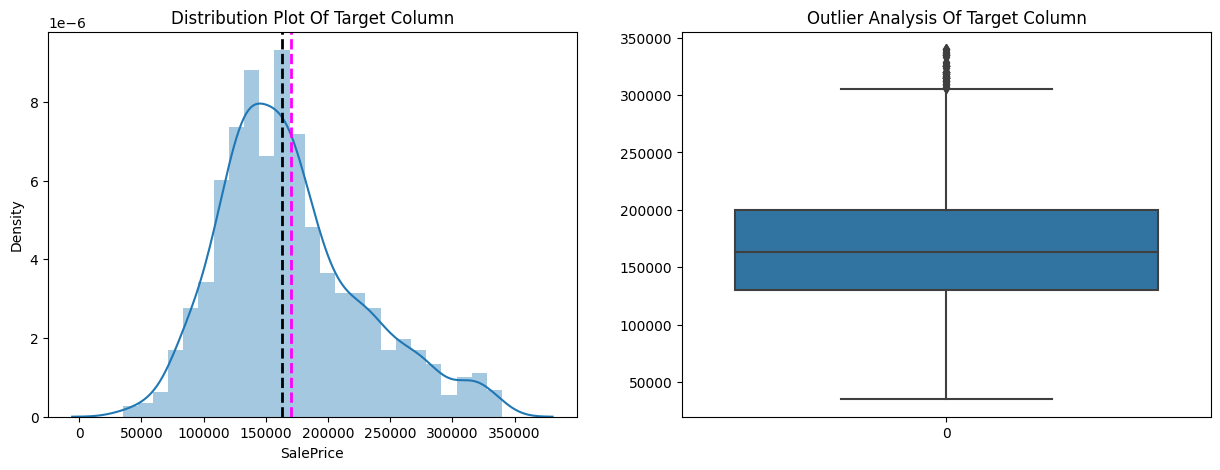

In [51]:
# Normal transformation of target column
fig, ax = plt.subplots(1, 2, figsize = (15,5))

# Distribution plot of saleprice
dist = sns.distplot(train_merge_df['SalePrice'], hist=True, ax=ax[0])
dist.set(xlabel='SalePrice', ylabel='Density', title='Distribution Plot Of Target Column')

# Mean line
dist.axvline(train_merge_df['SalePrice'].mean(), color='magenta', linestyle='dashed', linewidth=2)

# Median line
dist.axvline(train_merge_df['SalePrice'].median(), color='black', linestyle='dashed', linewidth=2)

# Boxplot of target column
box = sns.boxplot(train_merge_df.SalePrice, ax=ax[1])
box.set(title='Outlier Analysis Of Target Column')
plt.show()

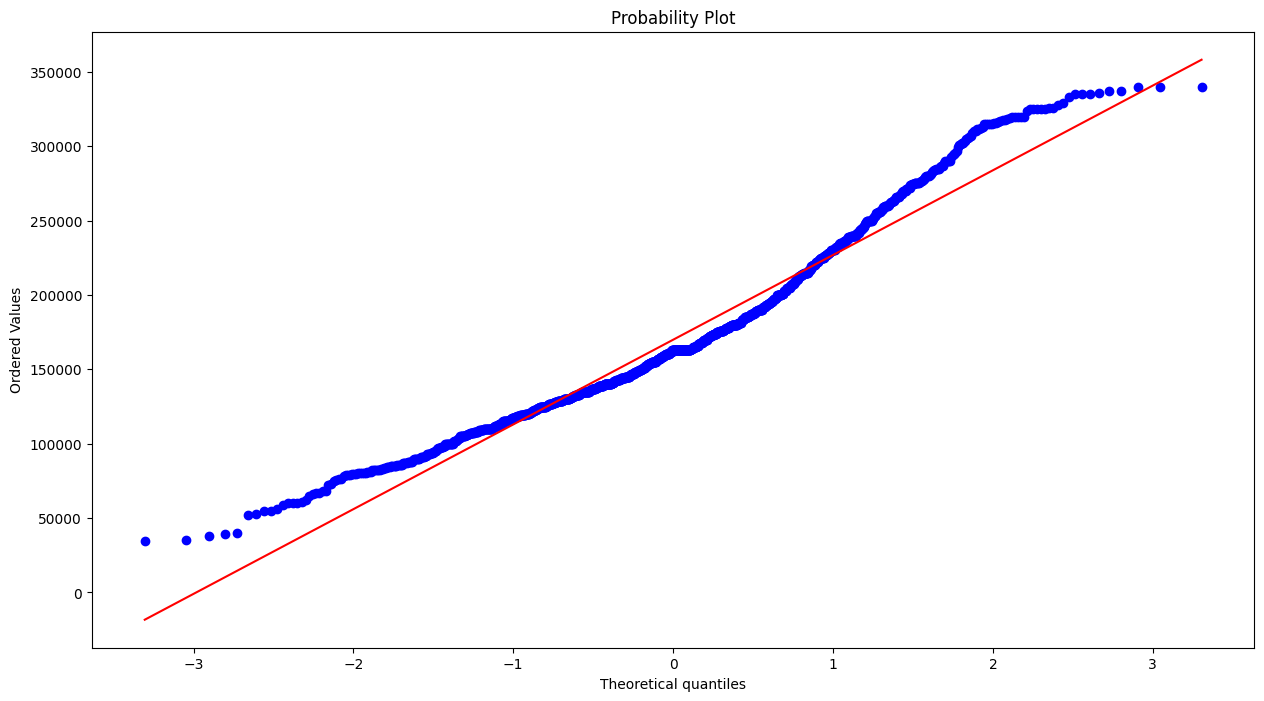

In [52]:
# Normal probability plot of target column
fig=plt.figure(figsize=(15,8))
stats.probplot(train_merge_df.SalePrice.tolist(), dist='norm', plot=plt)
plt.show()

# **14. Regression Model Building**

# *(I) Train/Test/Split*

In [53]:
# Copy train/test modified dataset
train_clean_df = train_merge_df.copy()
test_clean_df = test_merge_df.copy()

print("Task Completed Successfully!")

Task Completed Successfully!


In [54]:
# Identify the target column 
target = ["SalePrice"]

# Train_Test_Split
X_train = train_clean_df.drop(["Id", "SalePrice"], axis=1)
X_test = test_clean_df.drop(["Id"], axis=1)
Y_train = train_clean_df["SalePrice"]

print("Task completed successfully!")

Task completed successfully!


In [55]:
# Y_test to match with X_test rows
train_dummy_df = train_merge_df.copy()
values = [496]
train_dummy_df = train_dummy_df[train_dummy_df.Id.isin(values) == False]

Y_test = train_dummy_df["SalePrice"]

print("Y_test dataset shape :-", Y_test.shape)
Y_test.head()

Y_test dataset shape :- (1459,)


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [56]:
# Read Y_train dataset
print("Y_train dataset shape :-", Y_train.shape)
Y_train.head()

Y_train dataset shape :- (1460,)


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [57]:
# Read X_train dataset
print("X_train dataset shape :-", X_train.shape)
X_train.head()

X_train dataset shape :- (1460, 53)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,OverallGrade,HouseAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,60,3.0,65.0,8450.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,5.0,1.0,1.0,1.0,196.0,2.0,3.0,150.0,1.0,0.0,1.0,4.0,856,854,1710,3,1,2.0,5,6.0,0,1.0,1.0,2,2.0,0,2,8.0,4.0,6.0,5,5,706.0,1.0,2.5,61,2.0,12.5,3.0,2.5,3.5,4.0
1,20,3.0,80.0,9600.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,2.0,1.0,1.0,3.0,0.0,1.0,1.0,284.0,1.0,0.0,1.0,4.0,1262,0,1262,3,1,3.0,3,6.0,1,1.0,1.0,2,2.0,298,5,8.0,4.0,7.0,31,31,978.0,0.5,2.0,0,1.5,8.0,3.5,2.5,2.5,4.0
2,60,3.0,68.0,11250.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,5.0,1.0,1.0,1.0,162.0,2.0,2.0,434.0,1.0,0.0,1.0,4.0,920,866,1786,3,1,2.0,3,6.0,1,1.0,1.0,2,2.0,0,9,8.0,4.0,6.0,7,6,486.0,1.0,2.5,42,2.0,12.5,3.0,2.5,3.5,4.0
3,70,3.0,60.0,9550.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,5.0,1.0,1.0,3.0,0.0,0.0,3.0,540.0,1.0,2.0,1.0,4.0,961,756,1717,3,1,2.0,4,6.0,1,5.0,2.0,3,2.0,0,2,8.0,0.0,6.0,91,36,216.0,1.0,1.0,307,2.0,14.0,3.5,2.0,2.5,4.0
4,60,3.0,84.0,14260.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,5.0,1.0,1.0,1.0,350.0,2.0,0.0,490.0,1.0,0.0,1.0,4.0,1145,1053,2198,4,1,2.0,5,6.0,1,1.0,1.0,3,2.0,192,12,8.0,4.0,6.5,8,8,655.0,1.0,2.5,84,2.0,12.5,3.0,2.5,3.5,4.0


In [58]:
# Read X_test dataset
print("X_test dataset shape :-", X_test.shape)
X_test.head()

X_test dataset shape :- (1459, 53)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,HouseStyle,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,PavedDrive,WoodDeckSF,MoSold,SaleType,SaleCondition,OverallGrade,HouseAge,RemodAge,BsmtFinSF,BsmtBath,TotalFlrBath,TotalPorchSF,OverallCondition,OverallExterior,ExterGrade,BsmtGrade,BsmtFinTypeRating,GarageGrade
0,20,2.0,80.0,11622,1.0,3.0,3.0,0.0,4.0,0.0,12.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,270.0,0.0,4.0,1.0,3.0,896,0,896,2,1,3.0,3,6.0,0,1.0,2.0,1.0,2.0,140,6,8.0,4.0,5.5,49,49,612.0,0.0,1.0,0,1.5,11.0,3.5,3.0,3.5,3.5
1,20,3.0,81.0,14267,1.0,0.0,3.0,0.0,0.0,0.0,12.0,2.0,3.0,0.0,1.0,108.0,1.0,3.0,406.0,0.0,4.0,1.0,3.0,1329,0,1329,3,1,2.0,3,6.0,0,1.0,2.0,1.0,2.0,393,6,8.0,4.0,6.0,52,52,923.0,0.0,1.5,36,2.0,12.0,3.5,3.0,2.5,3.5
2,60,3.0,74.0,13830,1.0,0.0,3.0,0.0,4.0,0.0,8.0,4.0,1.0,0.0,3.0,0.0,2.0,3.0,137.0,0.0,2.0,1.0,3.0,928,701,1629,3,1,3.0,3,6.0,1,1.0,0.0,2.0,2.0,212,3,8.0,4.0,5.0,13,12,791.0,0.0,2.5,34,2.0,11.0,3.5,2.5,3.5,3.5
3,60,3.0,78.0,9978,1.0,0.0,3.0,0.0,4.0,0.0,8.0,4.0,1.0,0.0,1.0,20.0,2.0,3.0,324.0,0.0,0.0,1.0,3.0,926,678,1604,3,1,2.0,4,6.0,1,1.0,0.0,2.0,2.0,360,6,8.0,4.0,6.0,12,12,602.0,0.0,2.5,36,2.0,11.0,3.5,3.0,3.5,3.5
4,120,3.0,43.0,5005,1.0,0.0,1.0,0.0,4.0,0.0,22.0,2.0,1.0,0.0,3.0,0.0,2.0,3.0,1017.0,0.0,0.0,1.0,3.0,1280,0,1280,2,1,2.0,3,6.0,0,1.0,1.0,2.0,2.0,0,1,8.0,4.0,6.5,18,18,263.0,0.0,2.0,82,2.0,6.0,3.0,2.5,2.5,3.5


# *(II) Scale X_Train/X_Test Dataset*

In [59]:
# Scale X_train/X_test with standard scaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("X_train array :-", X_train)
print("**************************")
print("X_test array :-", X_test)

X_train array :- [[0.0734 -0.0455 -0.2741 ... -0.1266 -0.2464 0.1028]
 [-0.8726 -0.0455 0.8096 ... -0.1266 -1.1314 0.1028]
 [0.0734 -0.0455 -0.0574 ... -0.1266 -0.2464 0.1028]
 ...
 [0.3099 -0.0455 -0.2018 ... -0.9823 -0.2464 0.1028]
 [-0.8726 -0.0455 -0.0574 ... 0.7291 -0.6889 0.1028]
 [-0.8726 -0.0455 0.4484 ... 0.7291 -1.5739 0.1028]]
**************************
X_test array :- [[-0.8726 -1.6283 0.8096 ... 0.7291 -0.2464 -0.8183]
 [-0.8726 -0.0455 0.8819 ... 0.7291 -1.1314 -0.8183]
 [0.0734 -0.0455 0.3761 ... -0.1266 -0.2464 -0.8183]
 ...
 [-0.8726 -0.0455 -0.1296 ... 0.7291 -1.1314 -0.8183]
 [0.6646 -0.0455 -0.4908 ... -0.1266 -0.2464 1.0239]
 [0.0734 -0.0455 0.3761 ... -0.1266 0.1961 -0.8183]]


# *(III) Regression Model Training*

# **(A) Linear Regression Model**

In [60]:
# Train_Test_Split dataset
X_train, X_test, Y_train, Y_test

# Linear Regression Model
lr_model = LinearRegression()

# Fit the model
lr_trained_model = lr_model.fit(X_train, Y_train)

# Test dataset prediction
lr_test_pred = lr_trained_model.predict(X_test)

# Find training score
lr_accuracy = round(lr_trained_model.score(X_train, Y_train) * 100, 2)
print("The accuracy of the trained model is :-", lr_accuracy)

# Metric result
lr_mse = mean_squared_error(Y_test, lr_test_pred)
print("The mse of the trained model is :-", lr_mse)

lr_rmse = sqrt(mean_squared_error(Y_test, lr_test_pred))
print("The mse of the trained model is :-", lr_rmse)

lr_mae = mean_absolute_error(Y_test, lr_test_pred)
print("The mae of the trained model is :-", lr_mae)

lr_r2 = r2_score(Y_test, lr_test_pred)
print("The r2 of the trained model is :-", lr_r2)

The accuracy of the trained model is :- 72.81
The mse of the trained model is :- 5828896208.787833
The mse of the trained model is :- 76347.20825798303
The mae of the trained model is :- 60994.73334510841
The r2 of the trained model is :- -0.7393854185784308


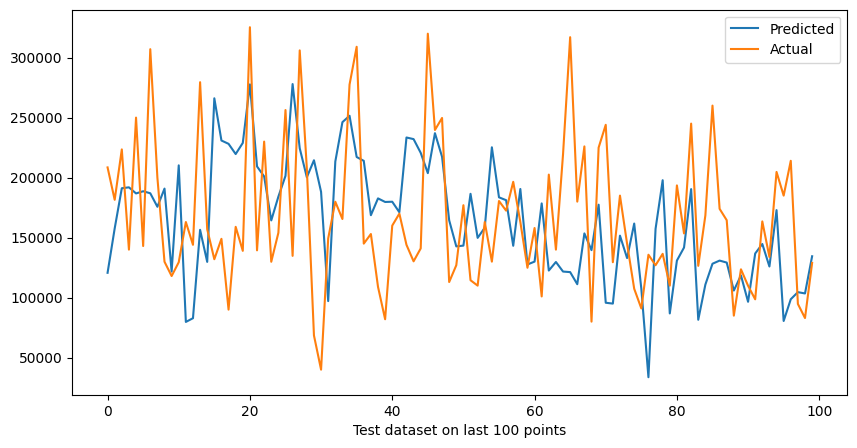

In [61]:
# Actual/Predicted on test data
plt.figure(figsize=(10,5))
plt.plot((lr_test_pred)[:100])
plt.plot((Y_test)[:100])
plt.legend(["Predicted", "Actual"])
plt.xlabel("Test dataset on last 100 points")
plt.show()

# **(B) Support Vector Regression Model**

In [62]:
# Train_Test_Split dataset
X_train, X_test, Y_train, Y_test

# SVM regression model
svmr_model = SVR(kernel='linear', C=1000)

# Fit the model
svmr_trained_model = svmr_model.fit(X_train, Y_train)

# Test dataset predictions
svmr_test_pred = svmr_trained_model.predict(X_test)

# Find training score
svmr_accuracy = round(svmr_trained_model.score(X_train, Y_train) * 100, 2)
print("The accuracy of the trained model is :-", svmr_accuracy)

# Metric result
svmr_mse = mean_squared_error(Y_test, svmr_test_pred)
print("The mse of the model is :-", svmr_mse)

svmr_rmse = sqrt(mean_squared_error(Y_test, svmr_test_pred))
print("The rmse of the model is :-", svmr_rmse)

svmr_mae = mean_absolute_error(Y_test, svmr_test_pred)
print("The mae of the model is :-", svmr_mae)

svmr_r2 = r2_score(Y_test, svmr_test_pred)
print("The r2 of the model is :-", svmr_r2)

The accuracy of the trained model is :- 70.48
The mse of the model is :- 6081440471.688849
The rmse of the model is :- 77983.5910412495
The mae of the model is :- 62186.32269972197
The r2 of the model is :- -0.8147464805533216


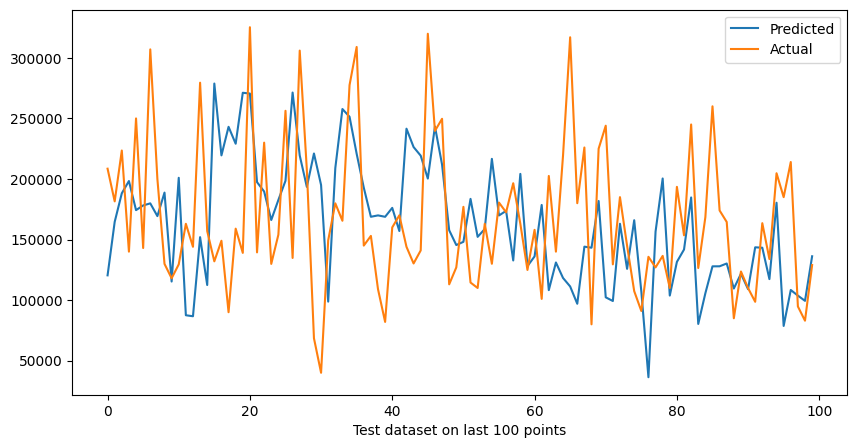

In [63]:
# Actual/Predicted on test data
plt.figure(figsize=(10,5))
plt.plot((svmr_test_pred)[:100])
plt.plot((Y_test)[:100])
plt.legend(["Predicted", "Actual"])
plt.xlabel("Test dataset on last 100 points")
plt.show()

# **(C) Light GBM Regression Model**

In [64]:
# Train_Test_Split dataset
X_train, X_test, Y_train, Y_test

# Light GBM Regression Model
lgbmr_model = LGBMRegressor(boosting_type = "gbdt", 
                            num_leaves = 3, 
                            max_depth = 8, 
                            learning_rate = 0.1,
                            n_estimators = 100, 
                            subsample_for_bin = 1200, 
                            min_child_weight = 0.001,
                            min_child_samples = 20, 
                            subsample = 1, 
                            colsample_bytree = 1, 
                            reg_alpha = 0.5,
                            reg_lambda = 0.5,
                            random_state = 53,
                            n_jobs = -1, 
                            force_row_wise = True)

# Fit the model
lgbmr_trained_model = lgbmr_model.fit(X_train, Y_train)

# Test dataset predictions
lgbmr_test_pred = lgbmr_trained_model.predict(X_test)

# Find training score
lgbmr_accuracy = round(lgbmr_trained_model.score(X_train, Y_train) * 100, 2)
print("The accuracy of the trained model is :-", lgbmr_accuracy)

# Metric result
lgbmr_mse = mean_squared_error(Y_test, svmr_test_pred)
print("The mse of the model is :-", lgbmr_mse)

lgbmr_rmse = sqrt(mean_squared_error(Y_test, lgbmr_test_pred))
print("The rmse of the model is :-", lgbmr_rmse)

lgbmr_mae = mean_absolute_error(Y_test, lgbmr_test_pred)
print("The mae of the model is :-", lgbmr_mae)

lgbmr_r2 = r2_score(Y_test, lgbmr_test_pred)
print("The r2 of the model is :-", lgbmr_r2)


[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 51
[LightGBM] [Info] Start training from score 169934.754110
The accuracy of the trained model is :- 79.67
The mse of the model is :- 6081440471.688849
The rmse of the model is :- 74669.68900730085
The mae of the model is :- 59723.33352680148
The r2 of the model is :- -0.6637887671590712


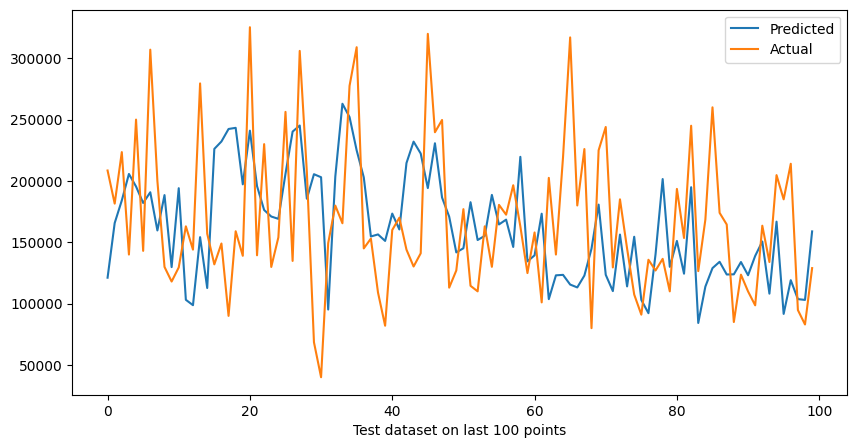

In [65]:
# Actual/Predicted on test data
plt.figure(figsize=(10,5))
plt.plot((lgbmr_test_pred)[:100])
plt.plot((Y_test)[:100])
plt.legend(["Predicted", "Actual"])
plt.xlabel("Test dataset on last 100 points")
plt.show()

# **(D) Xtreme Gradient Boosting Regression Model**

In [66]:
# Train_Test_Split dataset
X_train, X_test, Y_train, Y_test

# Light GBM Regression Model
xgbr_model = XGBRegressor(max_depth = 8, 
                          min_samples_leaf = 3, 
                          min_samples_split = 5, 
                          n_estimators = 100)

# Fit the model
xgbr_trained_model = xgbr_model.fit(X_train, Y_train)

# Test dataset predictions
xgbr_test_pred = xgbr_trained_model.predict(X_test)

# Find training score
xgbr_accuracy = round(xgbr_trained_model.score(X_train, Y_train) * 100, 2)
print("The accuracy of the trained model is :-", xgbr_accuracy)

# Metric result
xgbr_mse = mean_squared_error(Y_test, xgbr_test_pred)
print("The mse of the model is :-", xgbr_mse)

xgbr_rmse = sqrt(mean_squared_error(Y_test, xgbr_test_pred))
print("The rmse of the model is :-", xgbr_rmse)

xgbr_mae = mean_absolute_error(Y_test, xgbr_test_pred)
print("The mae of the model is :-", xgbr_mae)

xgbr_r2 = r2_score(Y_test, xgbr_test_pred)
print("The r2 of the model is :-", xgbr_r2)

The accuracy of the trained model is :- 100.0
The mse of the model is :- 5883614747.189364
The rmse of the model is :- 76704.72441244649
The mae of the model is :- 60715.375048192254
The r2 of the model is :- -0.7557138321257602


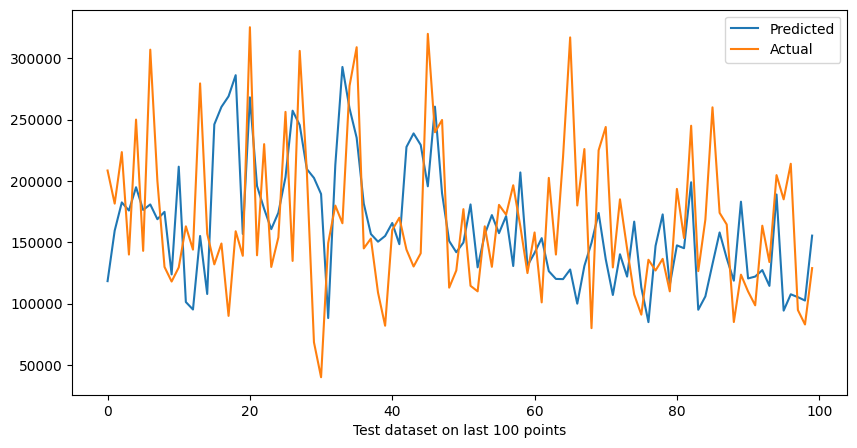

In [67]:
# Actual/Predicted on test data
plt.figure(figsize=(10,5))
plt.plot((xgbr_test_pred)[:100])
plt.plot((Y_test)[:100])
plt.legend(["Predicted", "Actual"])
plt.xlabel("Test dataset on last 100 points")
plt.show()

# **15. Save & Submit Model**

In [68]:
# Save the Xtreme Gradient Boosting Regression Model
model_path = '/kaggle/working/xgbr_trained_model.joblib'
dump(xgbr_trained_model, model_path)

print("Xtreme Gradient Boosting Regression Model Saved Successfully!")

Xtreme Gradient Boosting Regression Model Saved Successfully!


In [69]:
# Load the Xtreme Gradient Boosting Regression Model
load_model_path = '/kaggle/working/xgbr_trained_model.joblib'
xgbr_loaded_model = load(load_model_path)

print("Xtreme Gradient Boosting Regression Model Loaded Successfully!")

Xtreme Gradient Boosting Regression Model Loaded Successfully!


In [70]:
# Test XGB Regression Model saleprice prediction by sample data
sample_data = (60,3,102,12858,1,0,3,0,4,0,16,4,1,0,2,162,2,3,1590,0,0,1,3,1627,707,2334,3,1,0,7,6,1, 
              1,0,3,2,144,1,6,5,7,1,0,0,0,2.5,133,2,11,2,1.5,5,3.5)

sample_darray = np.asarray(sample_data).reshape(1,-1)

prediction = xgbr_loaded_model.predict(sample_darray)

print("SalePrice :-", prediction)

SalePrice :- [184465.6875]


In [71]:
# SalePrice prediction by XGB regression loaded model for test dataset
xgbr_loaded_pred = xgbr_loaded_model.predict(X_test)
print("Test dataset saleprice prediction :-", xgbr_loaded_pred)

Test dataset saleprice prediction :- [118326.1484 159502.5000 182503.0000 ... 154139.7969 116066.1016
 227150.2500]


In [72]:
# Display test dataset Id as index with saleprice prediction as pandas dataframe
kglhppvtwo_submission = pd.DataFrame({
                                      "Id": test_clean_df["Id"],
                                      "SalePrice": xgbr_loaded_pred
                                      })

kglhppvtwo_submission.head()

,Id,SalePrice
0,1461,118326.1484
1,1462,159502.5000
2,1463,182503.0000
3,1464,175883.3906
4,1465,194865.2188


In [73]:
# Save kglhppvtwo_submission dataframe in csv format
kglhppvtwo_submission.to_csv('/kaggle/working/kglhppvtwo_submission.csv', float_format='%.4f', index=False)

print("Task completed successfully!")

Task completed successfully!
